<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/4.%20Measurement%20Induced%20Dephasing%20Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [5]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 25.0 MB/s eta 0:00:00


In [6]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit
from numpy.random import uniform

# 9. Photon Number Sweeping

Sweeping Kappa, DD Sequence N

## 1) Hamiltonian & Function Setting

Lab Frame

$H_0 = -\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + g\sigma_x(a+a^\dagger)$

$H_1 = A(t) (\hat{a} + \hat{a}^\dagger) \cos{(\omega_{rd} t)}$

$H_2 = B(t) \sigma_x \cos{(\omega_{qd} t)}$

Rotating Frame

$H_0 = -\frac{\omega_q-\omega_{qd}}{2}\sigma_z + ({\omega_r-\omega_{rd}})a^\dagger a + \chi\sigma_z(a^\dagger a)$

$H_1 = \frac{A(t)}{2} (\hat{a} + \hat{a}^\dagger) $

$H_2 = \frac{B(t)}{2}  \sigma_x $

In [ ]:
# operator
N = 100

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

In [ ]:
sz = sigmaz()
sx = sigmax()
sy = sigmay()

sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)

In [ ]:
sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [ ]:
H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())

H1 = 0.5*tensor(qeye(2), a + a.dag())

H2_x = 0.5*sx_composite

In [ ]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-0.5*np.pi/A) * (t < T_cent+0.5*np.pi/A)

def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-0.5*np.pi/A) * (t < T_cent+0.5*np.pi/A)

In [ ]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square

# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    return f(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

In [ ]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [ ]:
# time-dependent envelope for qubit drive (rotating frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hqd_rotating_frame(t, args):

    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    Env = args['Env']
    Func = args['Func']

    B = args['B']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    f = Hrd_env(Env, 0)
    pulse = f(t, {'A': B}, T_srt)

    for T_cent in Seq:
      f = Hrd_env(Env, 1)
      pulse = pulse + f(t, {'A': B}, T_cent)

    f = Hrd_env(Env, 0)
    pulse = pulse + f(t, {'A': B}, T_end)

    return pulse

In [ ]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)

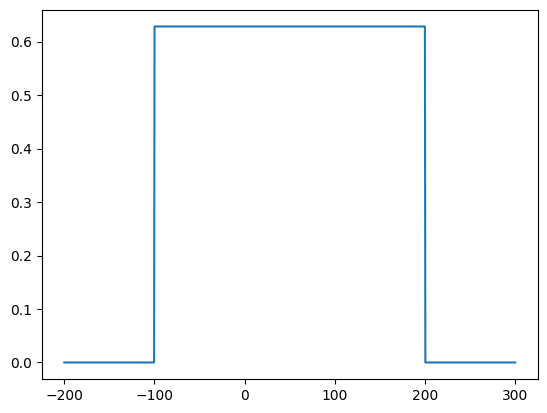

In [ ]:
# resonator pulse simulation (rotating frame)
tlist = np.linspace(-200, 300, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*0.1, 'T_srt_r': -100, 'T_end_r': 200}))

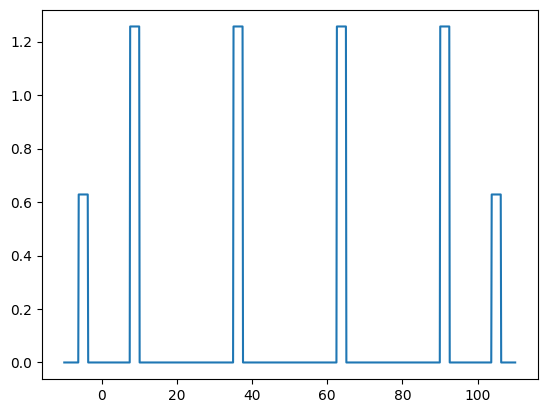

In [ ]:
# qubit pulse simulation (rotating frame)
tlist = np.linspace(-10, 110, 1000)
plt.figure()
plt.plot(tlist, Hqd_rotating_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': -5, 'T_end_q': 105, 'N_seq': 4, 'Env': 0, 'Func': 0}))

## 2) Photon Number

$\omega_r - \omega_{rd} = 0$

$\kappa = 2\pi0.002$

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.002   # external coupling rate of resonator in units of GHz

kai = g*g/(omega_r-omega_q)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, annihilate_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + kai*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

### $n$ = 0.001 to 0.01 regime

$A$ = [0.00089, 0.00126, 0.00155, 0.00179, 0.00201]

$\alpha$ = [-0.0044j, -0.0062j, -0.0076j, -0.0088j, -0.0099j]

$n$ = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
A = [0.00089, 0.00126, 0.00155, 0.00179, 0.00201]
alpha = [-0.0044j, -0.0062j, -0.0076j, -0.0088j, -0.0099j]
n = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

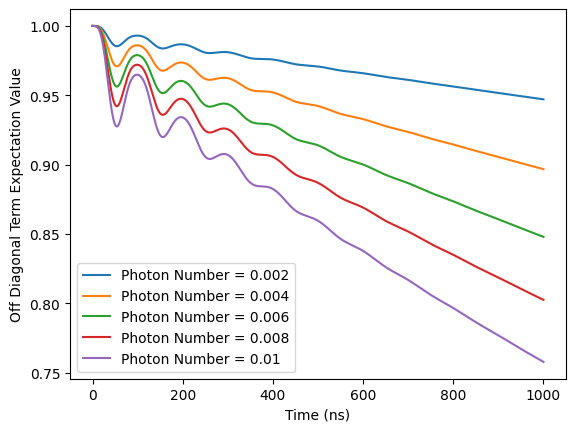

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

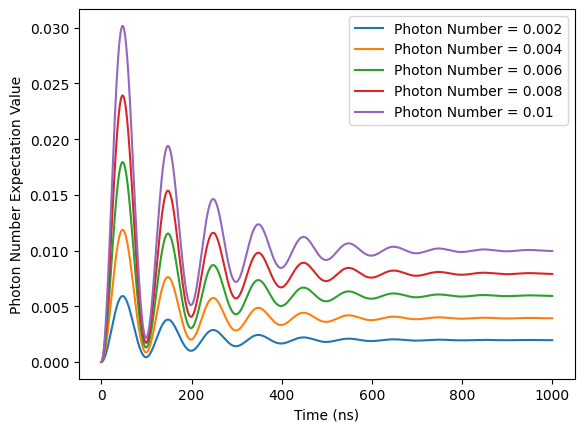

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(-1.6520101257735868e-18-0.004397712729416301j)
(-1.5273491878423077e-17-0.006225975316028945j)
(1.8787863888323847e-17-0.007658937913656151j)
(2.2375272792686963e-18-0.008844838037991198j)
(1.8079670104959275e-18-0.009931913191202933j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.001953327620632953
0.003915039682840648
0.005924592360157666
0.007901347100842655
0.009962932588974741


### $n$ = 0.01 to 0.1 regime

$A$ = [0.00284, 0.00402, 0.00493, 0.00569, 0.00626]

$\alpha$ = [-0.014j, -0.0198j, -0.0243j, -0.0281j, -0.0309j]

$n$ = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
A = [0.00284, 0.00402, 0.00493, 0.00569, 0.00626]
alpha = [-0.014j, -0.0198j, -0.0243j, -0.0281j, -0.0309j]
n = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

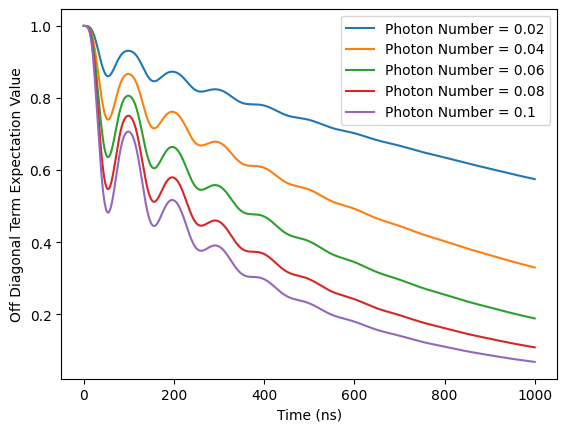

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

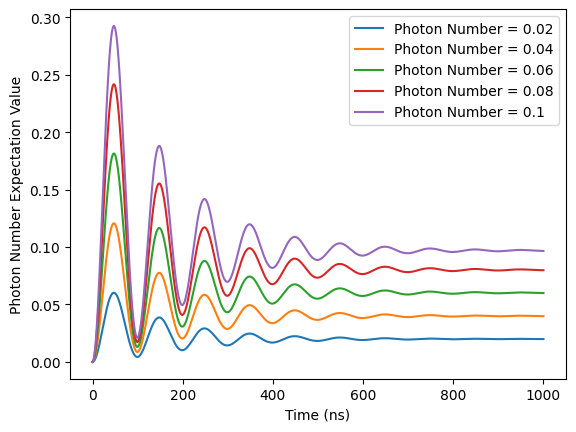

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(1.6061346101607437e-17-0.014033153792791696j)
(7.875161772154769e-17-0.019863890273907288j)
(4.5380637182096395e-17-0.024360741678707918j)
(-1.9607118663042544e-16-0.028117003167579792j)
(-1.8003515887300703e-16-0.03093511196363806j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.019889860972976115
0.03985171481865764
0.059936042270386264
0.0798393482976774
0.09663584064944761


### $n$ = 0.1 to 1 regime

$A$ = [0.009, 0.013, 0.016, 0.0185, 0.0207]

$\alpha$ = [-0.0445j, -0.0647j, -0.0785j, -0.0877j, -0.0959j]

$n$ = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
A = [0.009, 0.013, 0.016, 0.0185, 0.0207]
alpha = [-0.0445j, -0.0647j, -0.0785j, -0.0877j, -0.0959j]
n = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

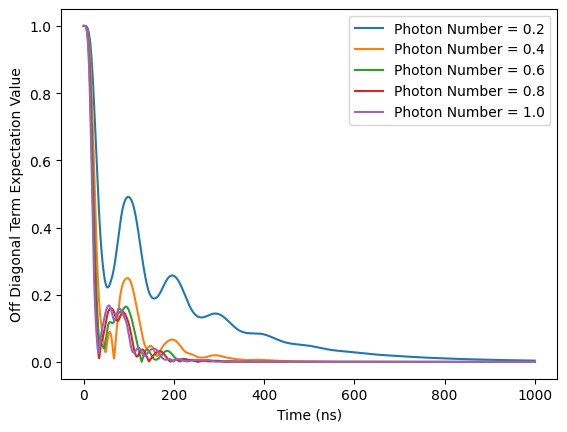

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

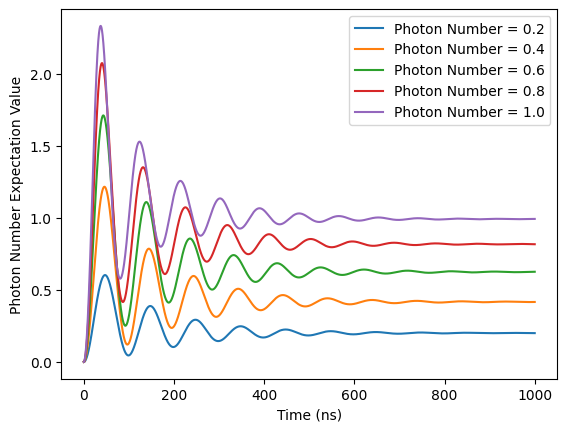

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(-2.8536201179818477e-16-0.04452509384046924j)
(3.0357660829594124e-18-0.06478825666154525j)
(2.3592239273284576e-16-0.07855618470954479j)
(6.626643678231403e-16-0.0877801627115436j)
(8.638922910364499e-16-0.09599246269590744j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.19970804542593032
0.4158665545561887
0.6254506443774949
0.8163581860402934
0.9919396267638871


## 3) Photon Number

$\omega_r - \omega_{rd} = 0$

$\kappa = 2\pi0.004$

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.004   # external coupling rate of resonator in units of GHz

kai = g*g/(omega_r-omega_q)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, annihilate_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + kai*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

### $n$ = 0.001 to 0.01 regime

$A$ = [0.00093,0.00129,0.00156,0.0018,0.00201]

$\alpha$ = [-0.0089j, -0.0124j, -0.015j, -0.0173j, -0.0193j]

$n$ = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
A = [0.00093,0.00129,0.00156,0.0018,0.00201]
alpha = [-0.0089j, -0.0124j, -0.015j, -0.0173j, -0.0193j]
n = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

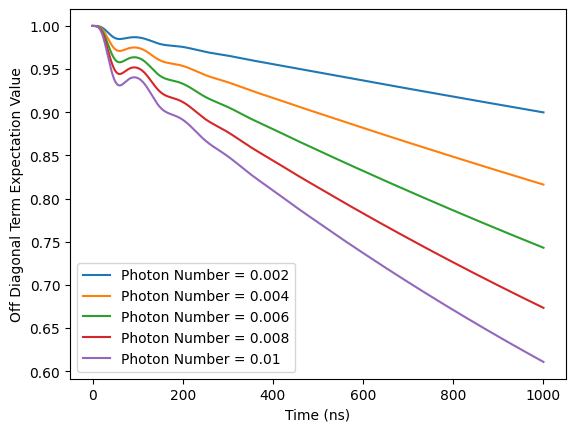

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

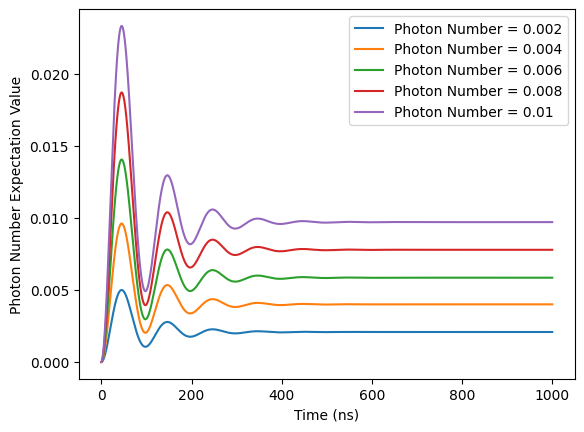

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(8.490570226703007e-18-0.008942276483116483j)
(6.290338912129541e-19-0.012403802889739184j)
(4.4482555610519e-18-0.01499994766968066j)
(-2.0272302156481656e-17-0.017307631904138282j)
(-3.753930660068668e-17-0.019326855560877713j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.0020790720318776402
0.004000212481828767
0.005849959190335758
0.0077884071959447325
0.009711711051120956


### $n$ = 0.01 to 0.1 regime

$A$ = [0.00285,0.00405,0.00498,0.00573,0.00642]

$\alpha$ = [-0.0634j, -0.0894j, -0.1096j, -0.1266j, -0.1416j]

$n$ = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
A = [0.00285,0.00405,0.00498,0.00573,0.00642]
alpha = [-0.0634j, -0.0894j, -0.1096j, -0.1266j, -0.1416j]
n = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

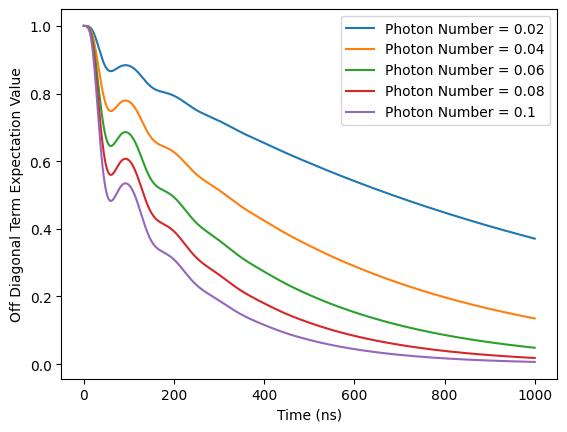

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

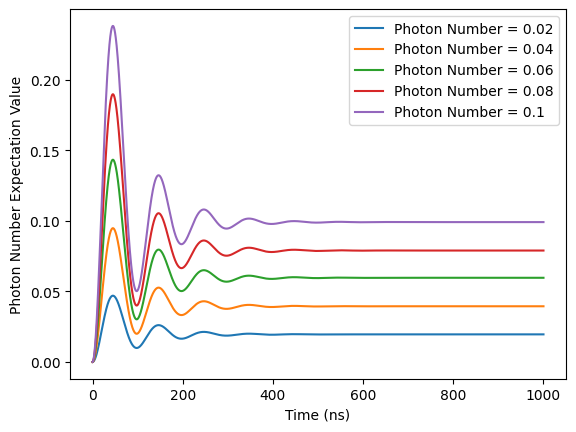

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(1.6203422643619545e-17-0.02740374976490198j)
(2.3302511653676243e-17-0.03894215332546331j)
(3.6339407503103993e-17-0.047884332082889454j)
(-2.4145521194431085e-17-0.05509556042796728j)
(1.2150179408594586e-16-0.061729465308195626j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.019525103613638337
0.03942879264607882
0.05961578483173451
0.07892411230713443
0.09907543805190255


### $n$ = 0.1 to 1 regime

$A$ = [0.009, 0.013, 0.016, 0.0185, 0.0207]

$\alpha$ = [-0.0865j, -0.1245j, -0.1517j, -0.1720j, -0.1869j]

$n$ = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
A = [0.009, 0.013, 0.016, 0.0185, 0.0207]
alpha = [-0.0865j, -0.1245j, -0.1517j, -0.1720j, -0.1869j]
n = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

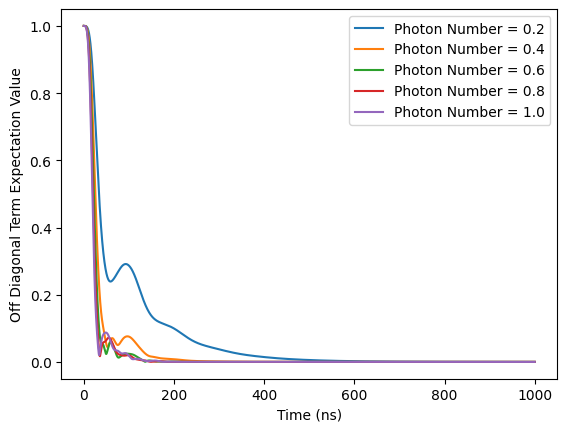

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

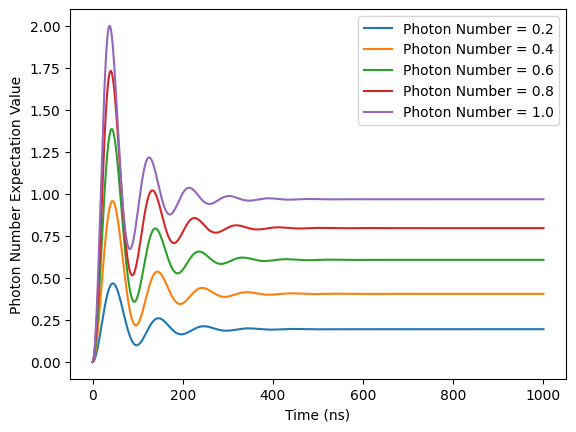

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(-3.1821333762449555e-16-0.08651798362805009j)
(-3.5518463170625125e-16-0.12457845495018964j)
(1.272419669628988e-15-0.1517691984658037j)
(4.562322741819003e-16-0.1720689431023219j)
(-2.42861286636753e-16-0.1869515922021788j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.194664592484279
0.4048751561964577
0.6070735672946171
0.795822736599303
0.9674729017812326


## 4) Photon Number

$\omega_r - \omega_{rd} = 0$

$\kappa = 2\pi0.006$

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.006   # external coupling rate of resonator in units of GHz

kai = g*g/(omega_r-omega_q)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, annihilate_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + kai*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

### $n$ = 0.001 to 0.01 regime

$A$ = [0.00099,0.00135,0.00162,0.00186,0.00207]

$\alpha$ = [-0.0136j, -0.01857j, -0.02229j, -0.02559j, -0.02848j]

$n$ = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
A = [0.00099,0.00135,0.00162,0.00186,0.00207]
alpha = [-0.0136j, -0.01857j, -0.02229j, -0.02559j, -0.02848j]
n = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

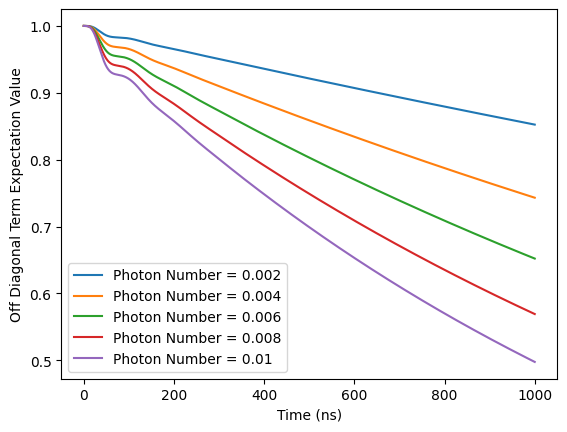

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

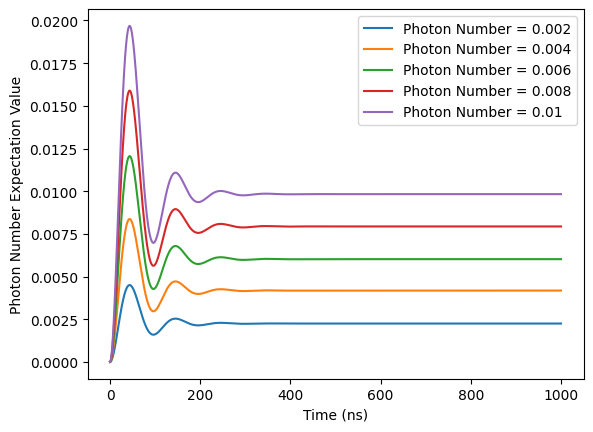

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(-9.573691668331165e-19-0.013623853111567226j)
(1.5617740719623824e-18-0.018577981504441878j)
(-1.7394876227148063e-18-0.022293577807147504j)
(-6.0785077800244845e-19-0.025596330035258283j)
(-2.3721110538561765e-17-0.02848623827098299j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.002247935748769124
0.004180045811277304
0.006019265968729927
0.007934862259255002
0.00982775213948666


### $n$ = 0.01 to 0.1 regime

$A$ = [0.00294,0.00414,0.0051,0.00588,0.00657,]

$\alpha$ = [-0.0404j, -0.05697j, -0.0701j, -0.08091j, -0.09041j]

$n$ = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
A = [0.00294,0.00414,0.0051,0.00588,0.00657,]
alpha = [-0.0404j, -0.05697j, -0.0701j, -0.08091j, -0.09041j]
n = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

/usr/local/lib/python3.10/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Text(0, 0.5, 'Off Diagonal Term Expectation Value')

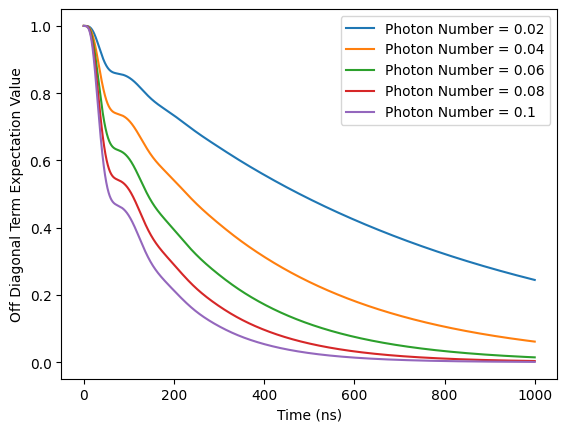

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

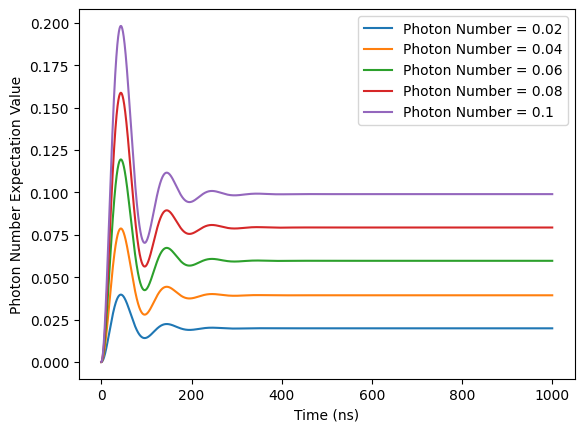

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(1.7044394011345057e-17-0.040458714054807915j)
(9.46891778988478e-17-0.05697244970949465j)
(-1.404973549610708e-17-0.07018331393630668j)
(-6.797608808305211e-17-0.08091682717120266j)
(1.0316522484378476e-16-0.09041124541970535j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.01982476975774545
0.0393109900434437
0.05965581645616365
0.07929849010778049
0.09900031308037535


### $n$ = 0.1 to 1 regime

$A$ = [0.0095, 0.0135, 0.0165, 0.019, 0.0215]

$\alpha$ = [-0.1306j, -0.1850j, -0.2238j, -0.2527j, -0.2765j]

$n$ = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
A = [0.0095, 0.0135, 0.0165, 0.019, 0.0215]
alpha = [-0.1306j, -0.1850j, -0.2238j, -0.2527j, -0.2765j]
n = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

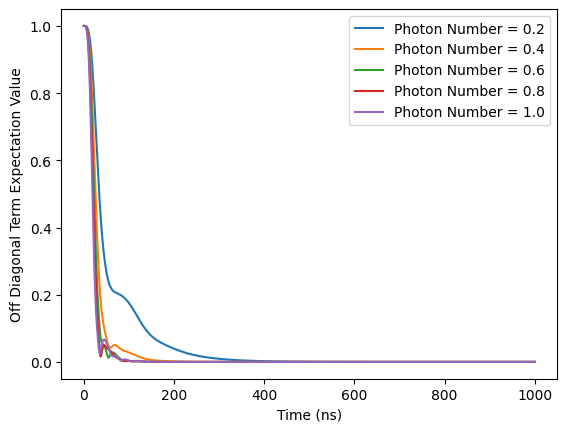

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

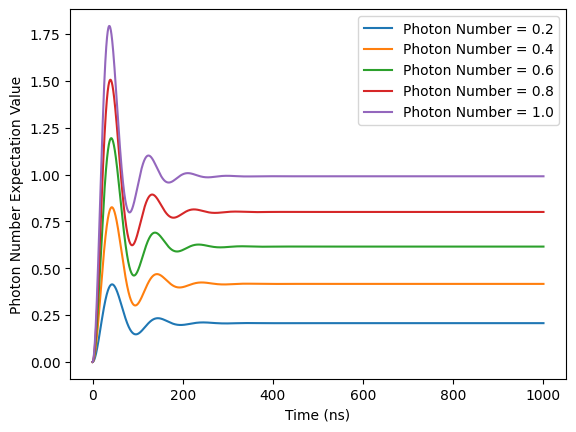

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(1.1741909528018013e-16-0.13069543741450731j)
(2.3548871186385156e-16-0.18508674126096433j)
(4.553649124439119e-16-0.22385158722597914j)
(-1.0547118733938987e-15-0.2527620648134033j)
(-1.824929096727601e-15-0.2765068283021455j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.2069344409455101
0.41644516128230313
0.6155918627826871
0.8004132078072712
0.9908161355681404


## 5) Photon Number

$\omega_r - \omega_{rd} = 0$

$\kappa = 2\pi0.008$

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.008   # external coupling rate of resonator in units of GHz

kai = g*g/(omega_r-omega_q)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, annihilate_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + kai*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

### $n$ = 0.001 to 0.01 regime

$A$ = [0.00099,0.00138,0.00165,0.00192,0.00213]

$\alpha$ = [-0.017j, -0.02379j, -0.02844j, -0.0331j, -0.03672j]

$n$ = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
A = [0.00099,0.00138,0.00165,0.00192,0.00213]
alpha = [-0.017j, -0.02379j, -0.02844j, -0.0331j, -0.03672j]
n = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

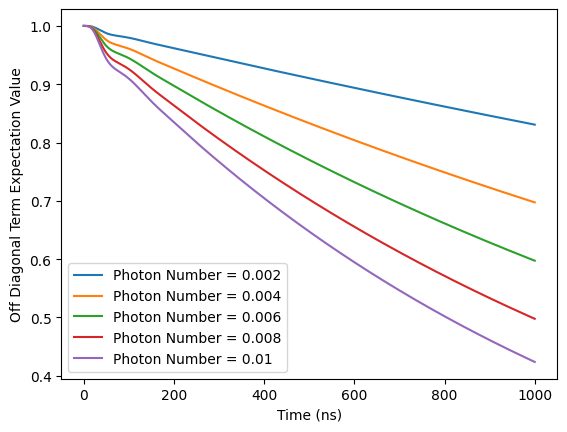

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

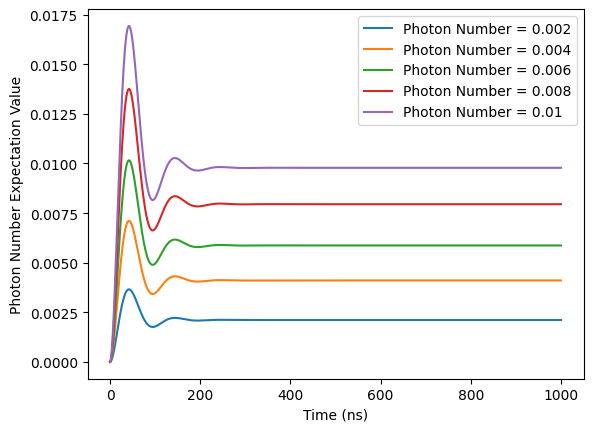

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(-1.5959019155244894e-19-0.017068965491123106j)
(2.3542017767535486e-18-0.023793103429070473j)
(-6.8888978669136046e-18-0.02844827582820791j)
(-2.8684208275950345e-18-0.033103448196404685j)
(1.8927013244943283e-17-0.036724137797592434j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.002112284479500795
0.004104310341464741
0.005867456889496526
0.007944827567040505
0.009777801688490068


### $n$ = 0.01 to 0.1 regime

$A$ = [0.00303,0.00429,0.00525,0.00606,0.00678]

$\alpha$ = [-0.05224j, -0.07396j, -0.09051j, -0.10448j, -0.11689j]

$n$ = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
A = [0.00303,0.00429,0.00525,0.00606,0.00678]
alpha = [-0.05224j, -0.07396j, -0.09051j, -0.10448j, -0.11689j]
n = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

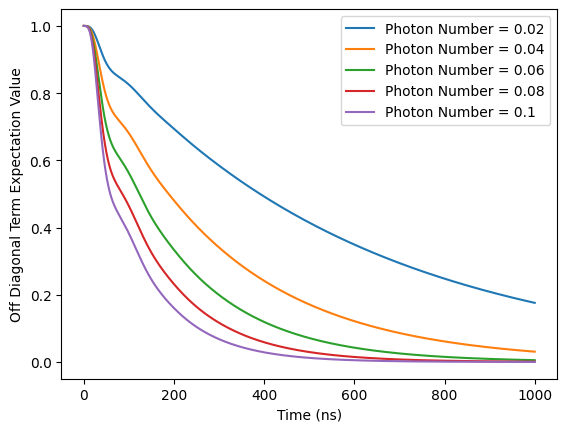

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

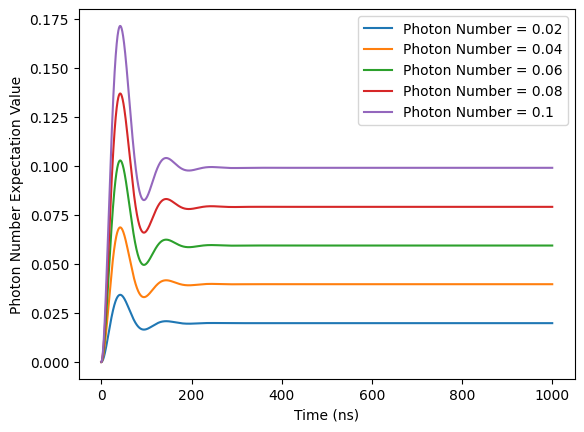

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(-5.471766664813776e-18-0.0522413776709824j)
(-1.462455322993753e-17-0.07396548094890408j)
(2.1396052247643627e-17-0.09051702342522162j)
(1.2405644545486483e-17-0.10448198522847635j)
(-1.0504563798668931e-16-0.11689448010173363j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.019786421792643945
0.039663989158367295
0.05940179662207748
0.07914510380960366
0.09906807188500241


### $n$ = 0.1 to 1 regime

$A$ = [0.0095, 0.0135, 0.0175, 0.020, 0.0225]

$\alpha$ = [-0.16375j, -0.2320j, -0.2966j, -0.3319j, -0.3606j]

$n$ = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
A = [0.0095, 0.0135, 0.0175, 0.020, 0.0225]
alpha = [-0.16375j, -0.2320j, -0.2966j, -0.3319j, -0.3606j]
n = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

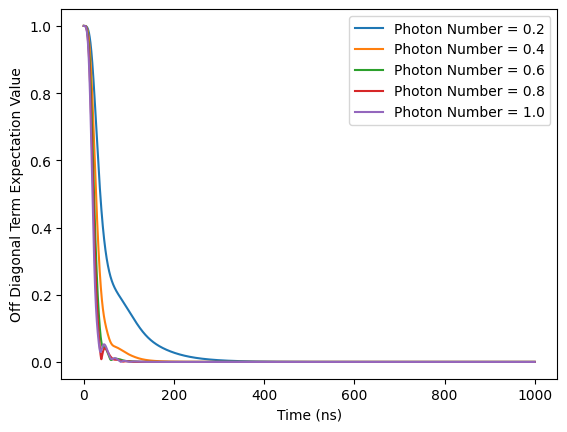

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

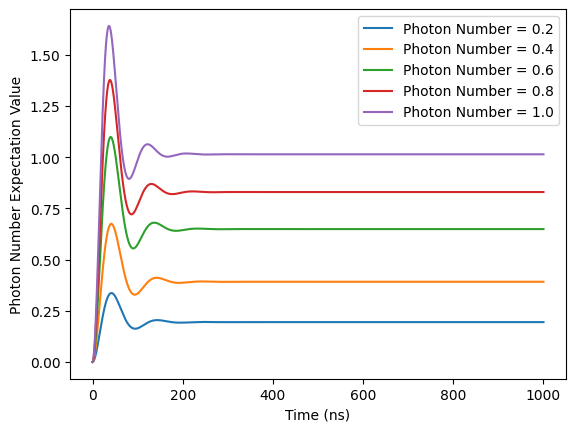

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(2.293087594806842e-17-0.16375488850187778j)
(-4.579669976578771e-16-0.23205902731021735j)
(-1.932481952238163e-15-0.2966423520848998j)
(-1.0234868508263162e-15-0.3319410962574235j)
(-1.0061396160665481e-16-0.3606124245410327j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.1944589300933507
0.39159960857744697
0.6489051451876171
0.8298527406428148
1.0142224440228806


## 6) Photon Number

$\omega_r - \omega_{rd} = 0$

$\kappa = 2\pi0.010$

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01    # external coupling rate of resonator in units of GHz

kai = g*g/(omega_r-omega_q)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, annihilate_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + kai*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

### $n$ = 0.001 to 0.01 regime

$A$ = [0.00101, 0.00142, 0.00173, 0.00200, 0.00224]

$\alpha$ = [-0.0202j, -0.0284j, -0.0346j, -0.04j, -0.0448j]

$n$ = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
A = [0.00101, 0.00142, 0.00173, 0.00200, 0.00224]
alpha = [-0.0202j, -0.0284j, -0.0346j, -0.04j, -0.0448j]
n = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

/usr/local/lib/python3.10/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Text(0, 0.5, 'Off Diagonal Term Expectation Value')

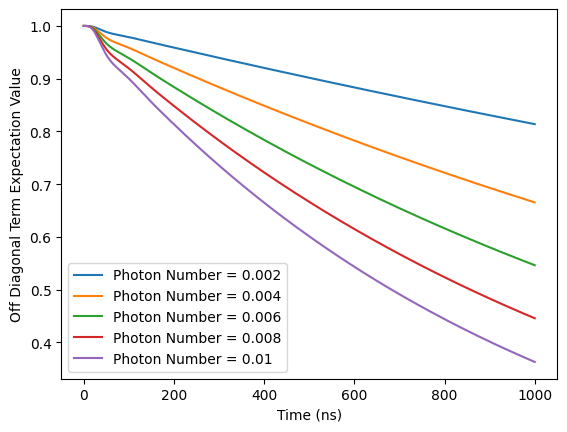

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

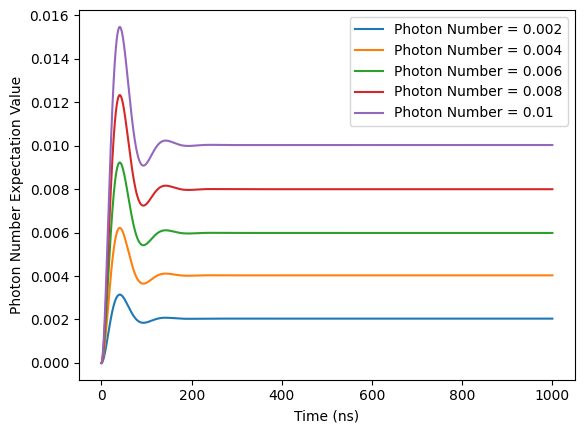

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(-1.3632899449429181e-18-0.02019999997095013j)
(-4.1945556999654945e-18-0.02839999996405353j)
(6.957063546447415e-18-0.034599999964840866j)
(1.1065209529782571e-17-0.03999999993962982j)
(-2.3511583207860246e-18-0.04479999984694793j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.002040199997065917
0.004032799994895511
0.005985799993917339
0.007999999987925789
0.010035199965716115


### $n$ = 0.01 to 0.1 regime

$A$ = [0.00317, 0.00447, 0.00548, 0.00633, 0.00708]

$\alpha$ = [-0.0634j, -0.0894j, -0.1096j, -0.1266j, -0.1416j]

$n$ = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
A = [0.00317, 0.00447, 0.00548, 0.00633, 0.00708]
alpha = [-0.0634j, -0.0894j, -0.1096j, -0.1266j, -0.1416j]
n = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

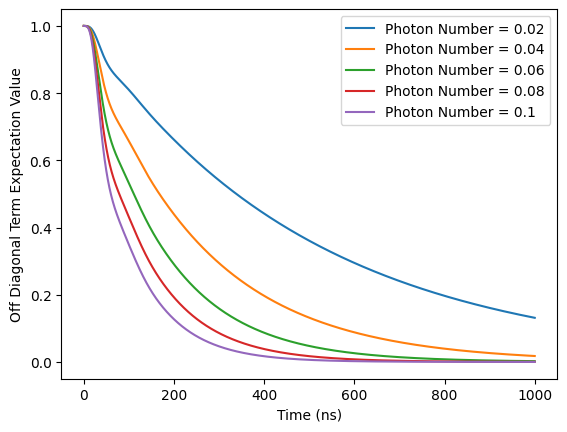

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

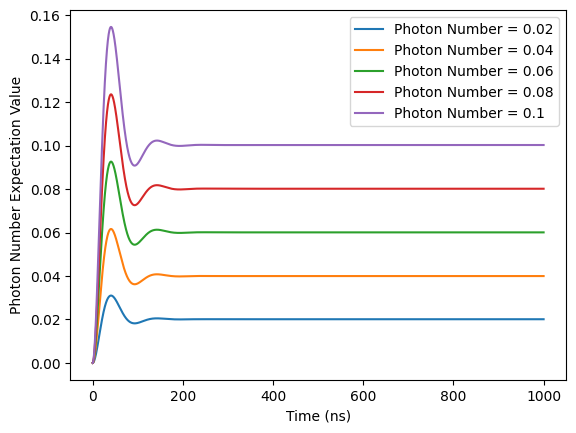

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(2.0206407708114763e-17-0.06339999786447838j)
(1.4848911081841512e-17-0.08939995482006444j)
(-1.0944089194999188e-17-0.10959972442203654j)
(2.5333061386481615e-17-0.12659901624633885j)
(-2.1541741914571366e-17-0.1415973724904493j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.0200977993230392
0.0399617798045679
0.06006064898327467
0.08013717728393066
0.10025093972323577


### $n$ = 0.1 to 1 regime

$A$ = [0.01, 0.01425, 0.0175, 0.0203, 0.023]

$\alpha$ = [-0.200j, -0.285j, -0.350j, -0.406j, -0.460j]

$n$ = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
A = [0.01, 0.01425, 0.0175, 0.0203, 0.023]
alpha = [-0.200j, -0.285j, -0.350j, -0.406j, -0.460j]
n = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

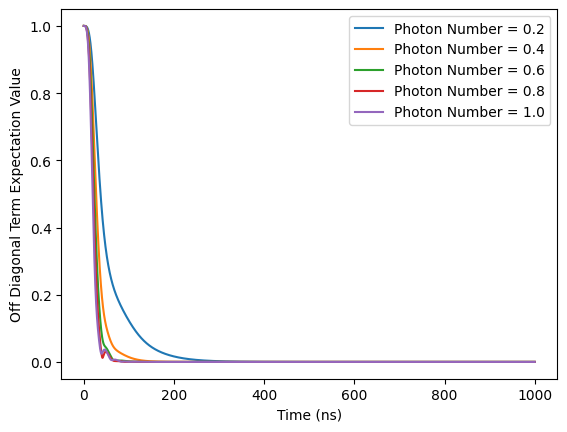

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

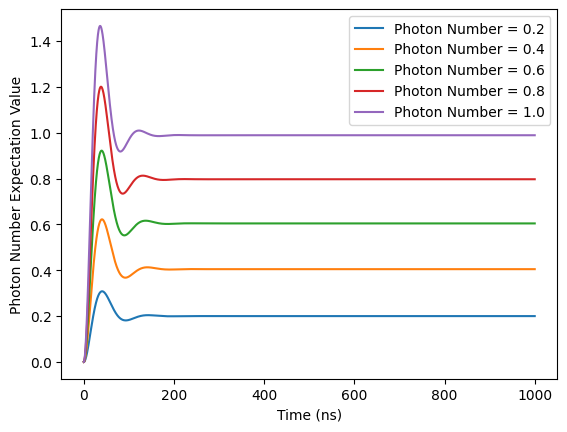

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(4.2961511084738113e-16-0.19994819994819607j)
(2.174909558005922e-16-0.284037780810038j)
(9.13331910101789e-16-0.34534227653573146j)
(-9.575673587391975e-16-0.3926602977195714j)
(1.5092094240998222e-15-0.43005410337521316j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.1999481999481912
0.40475383765429085
0.6043489839375281
0.7971004043707303
0.9891244377629893


## 7) Photon Number

$\omega_r - \omega_{rd} = 0$

$\kappa = 2\pi0.012$

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.012   # external coupling rate of resonator in units of GHz

kai = g*g/(omega_r-omega_q)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, annihilate_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + kai*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

### $n$ = 0.001 to 0.01 regime

$A$ = [0.00111,0.00153,0.00183,0.0021,0.00234]

$\alpha$ = [-0.02448j, -0.0337j, -0.040367j, -0.04632j, -0.051617j]

$n$ = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
A = [0.00111,0.00153,0.00183,0.0021,0.00234]
alpha = [-0.02448j, -0.0337j, -0.040367j, -0.04632j, -0.051617j]
n = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

/usr/local/lib/python3.10/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Text(0, 0.5, 'Off Diagonal Term Expectation Value')

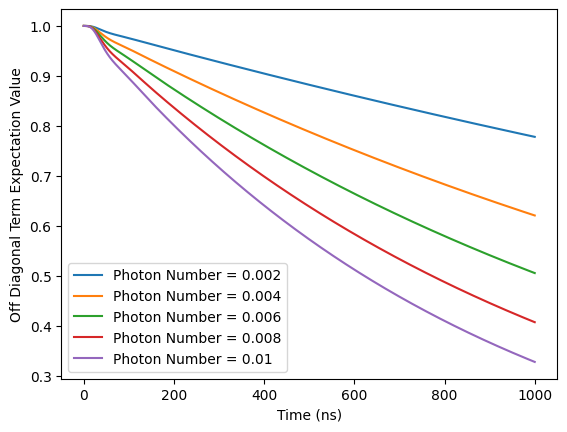

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

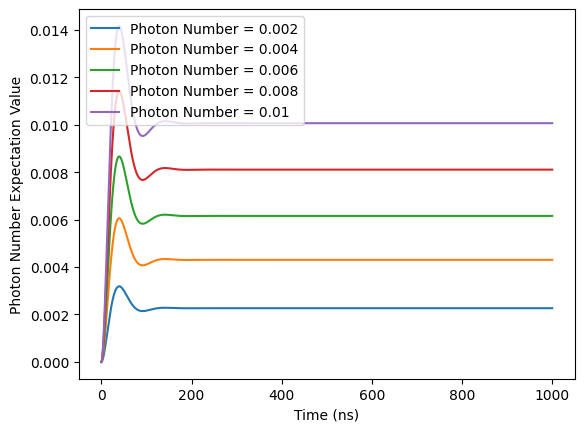

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(-4.642855144517238e-18-0.02448529410562067j)
(-1.4150015222152343e-18-0.03374999998739837j)
(1.8325359290499775e-19-0.040367647004224905j)
(-2.3625020689114237e-17-0.04632352927074997j)
(2.074369873909552e-17-0.051617646884968026j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.002264889704769909
0.004303124998393287
0.0061560661681442945
0.008106617622381232
0.010065441142568757


### $n$ = 0.01 to 0.1 regime

$A$ = [0.00327, 0.00457, 0.00568, 0.00653, 0.00728]

$\alpha$ = [-0.0721j, -0.1008j, -0.1253j, -0.1440j, -0.16058j]

$n$ = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
A = [0.00327, 0.00457, 0.00568, 0.00653, 0.00728]
alpha = [-0.0721j, -0.1008j, -0.1253j, -0.1440j, -0.16058j]
n = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

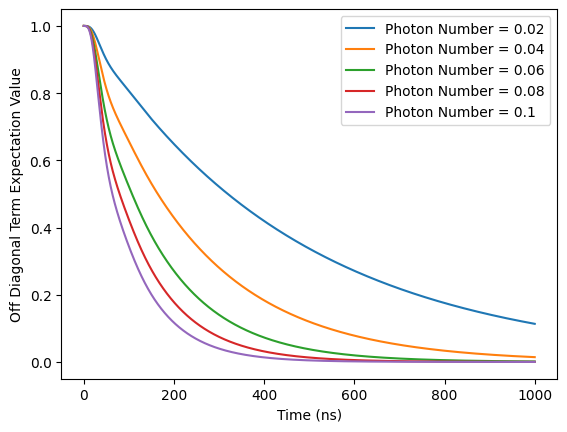

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

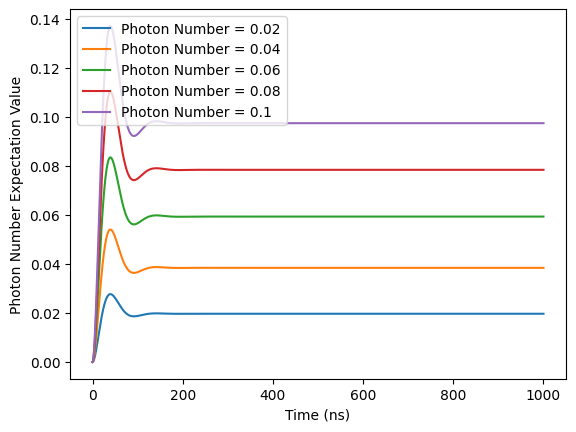

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(3.517940911672903e-17-0.0721323507367995j)
(-5.2357647568630067e-17-0.10080878004677625j)
(-4.428711764719109e-18-0.12529381786668037j)
(1.307107362884946e-16-0.14404309089130526j)
(-4.911774654538237e-17-0.16058556835088703j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.019656065575777825
0.03839134373448059
0.05930574045689536
0.07838344862668518
0.09742191146620469


### $n$ = 0.1 to 1 regime

$A$ = [0.0112, 0.01525, 0.0185, 0.0213, 0.024]

$\alpha$ = [-0.24695j, -0.3350j, -0.4021j, -0.4538j, -0.4948j]

$n$ = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
A = [0.0112, 0.01525, 0.0185, 0.0213, 0.024]
alpha = [-0.24695j, -0.3350j, -0.4021j, -0.4538j, -0.4948j]
n = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

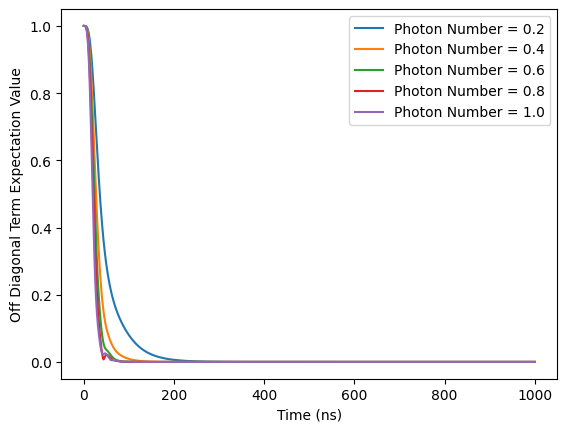

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

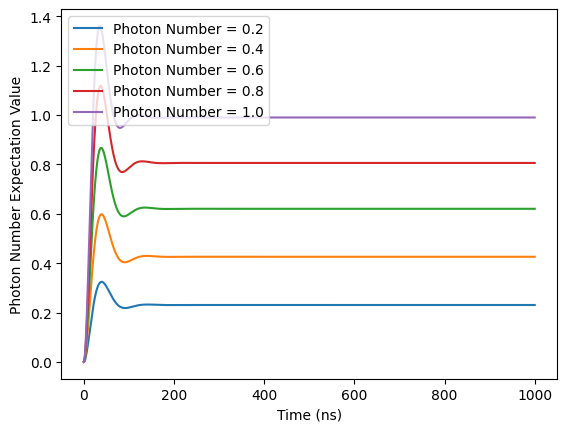

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(4.031605778387348e-16-0.24695008760112763j)
(1.3487475025719675e-16-0.33504098135469274j)
(8.612902058224847e-16-0.4021754067851564j)
(-2.671474153004283e-16-0.45387950561134666j)
(3.920475055707584e-16-0.4948780622387392j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.23048674842771913
0.425781247138256
0.6200204187937823
0.8056361224601397
0.9897561244774798


## 8) Photon Number

$\omega_r - \omega_{rd} = 0$

$\kappa = 2\pi0.014$

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.014   # external coupling rate of resonator in units of GHz

kai = g*g/(omega_r-omega_q)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, annihilate_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + kai*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

### $n$ = 0.001 to 0.01 regime

$A$ = [0.00111,0.00153,0.00193,0.0022,0.00244]

$\alpha$ = [-0.02607j, -0.03594j, -0.04533j, -0.05167j, -0.0573j]

$n$ = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
A = [0.00111,0.00153,0.00193,0.0022,0.00244]
alpha = [-0.02607j, -0.03594j, -0.04533j, -0.05167j, -0.0573j]
n = [0.002, 0.004, 0.006, 0.008, 0.010]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

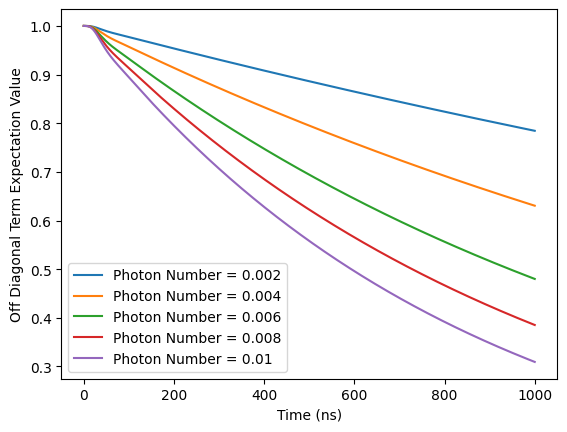

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

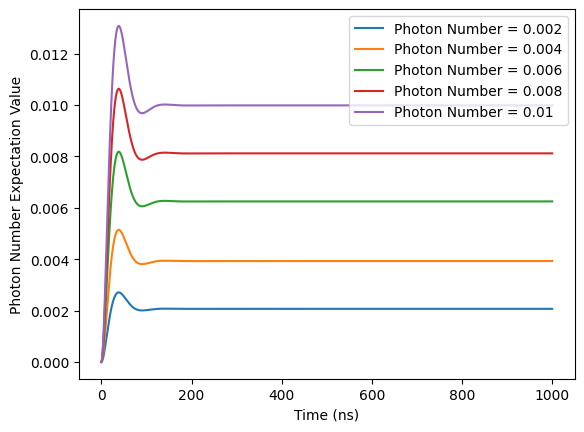

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(9.495129284925146e-19-0.026073825498822197j)
(1.1577158331734117e-18-0.03593959728634188j)
(9.195072038037464e-19-0.045335570447675264j)
(4.800989362482275e-19-0.05167785229537197j)
(-1.044775435768777e-18-0.057315436012082964j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.002067281878835191
0.003927684560578795
0.006249832211715239
0.008120805360701316
0.009989261704963042


### $n$ = 0.01 to 0.1 regime

$A$ = [0.00337, 0.00482, 0.006, 0.00683, 0.00768]

$\alpha$ = [-0.07916j, -0.1132j, -0.1409j, -0.1604j, -0.1804j]

$n$ = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
A = [0.00337, 0.00482, 0.006, 0.00683, 0.00768]
alpha = [-0.07916j, -0.1132j, -0.1409j, -0.1604j, -0.1804j]
n = [0.02, 0.04, 0.06, 0.08, 0.10]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

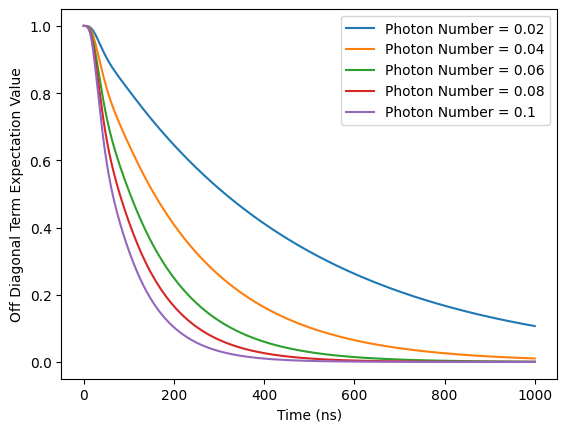

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

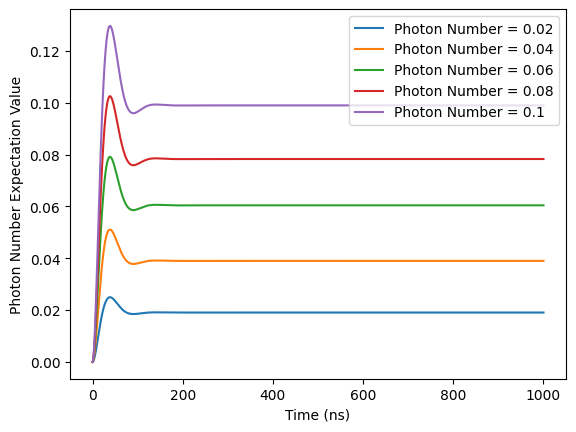

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(2.4068877947594372e-17-0.07916107168812275j)
(1.7097360040328052e-17-0.11322142464409908j)
(-1.0993217105939937e-17-0.14093923495490043j)
(5.0850775955464667e-17-0.1604351044884408j)
(1.6642503347652493e-17-0.18039950074168734j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.019055200827783864
0.038980519056039914
0.060402529266385924
0.07826941168971802
0.09896201183544001


### $n$ = 0.1 to 1 regime

$A$ = [0.0112, 0.01525, 0.0185, 0.0213, 0.024]

$\alpha$ = [-0.263j, -0.3583j, -0.4511j, -0.5005j, -0.5568j]

$n$ = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
A = [0.0112, 0.0153, 0.0195, 0.022, 0.0255]
alpha = [-0.263j, -0.3583j, -0.4511j, -0.5005j, -0.5568j]
n = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
plus_list = []
alpha_list = []
n_list = []

for i in range(5):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*20+10, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(np.sqrt((result.expect[0])**2 + (result.expect[1])**2))
  alpha_list.append(result.expect[3])
  n_list.append(result.expect[4])

Text(0, 0.5, 'Off Diagonal Term Expectation Value')

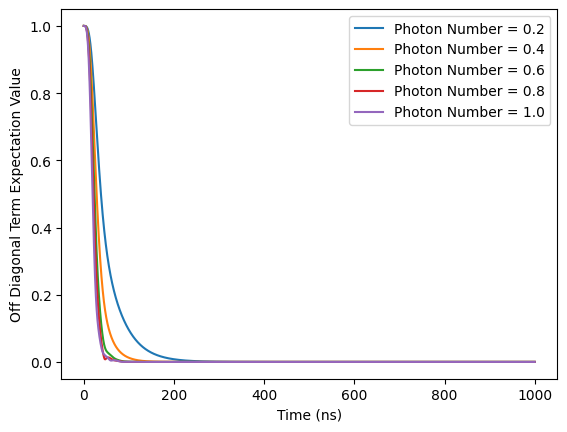

In [ ]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, plus_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

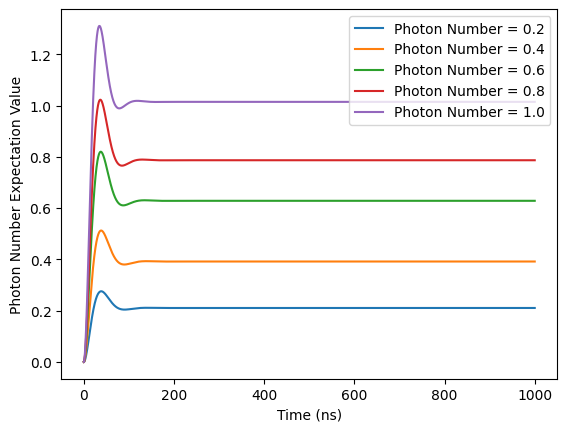

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(5):
  ax.plot(tlist, n_list[i], label = 'Photon Number = {0}'.format(n[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [ ]:
for i in range(5):
  print(alpha_list[i][-1])

(1.8561541192951836e-16-0.26300478862229254j)
(7.296680620827445e-16-0.35831586329501286j)
(-4.666406150377611e-16-0.45111720715690995j)
(2.896988204881268e-16-0.5005115593438684j)
(-1.2351231148954867e-15-0.5568145855055492j)


In [ ]:
for i in range(5):
  print(n_list[i][-1])

0.21040383089783438
0.3915880506009793
0.628341824254269
0.786518164683222
1.0141979950279636


## 9) Summary

n 0.004

0.00126,0.00129,0.00135,0.00138,0.00142,0.00153,0.00153

-0.0062j,-0.0124j,-0.01857j,-0.02379j,-0.0284j,-0.0337j,-0.03594j


n 0.01

0.00201,0.00201,0.00207,0.00213,0.00224,0.00234,0.00244

-0.0099j,-0.0193j,-0.02848j,-0.03672j,-0.0448j,-0.051617j,-0.0573j


n 0.04

0.00402,0.00405,0.00414,0.00429,0.00447,0.00457,0.00482

-0.0198j,-0.0894j,-0.05697j,-0.07396j,-0.0894j,-0.1008j,-0.1132j


n 0.1

0.00626,0.00642,0.00657,0.00678,0.00708,0.00728,0.00768

-0.0309j,-0.1416j,-0.09041j,-0.11689j,-0.1416j,-0.16058j,-0.1804j


n 0.4

0.013,0.013,0.0135,0.0135,0.01425,0.01525,0.01525

-0.0647j,-0.1245j,-0.1850j,-0.2320j,-0.285j,-0.3350j,-0.3583j


n 1

0.0207,0.0207,0.0215,0.0225,0.023,0.024,0.024

-0.0959j,-0.1869j,-0.2765j,-0.3606j,-0.460j,-0.4948j,-0.5568j

# 10. Measurement Induced Dephasing Dynamical Decoupling - Initial State : Coherent State + Detune

## 1) Filtering Function (μs, MHz scale)

In [ ]:
omega_list = np.linspace(0,10,10000)

def filter(omega_list, tau, N):

  if N==0:
    f = (4*np.sin(2*np.pi*tau*omega_list/2)*np.sin(2*np.pi*tau*omega_list/2))/(2*np.pi*2*np.pi*omega_list**2)
    return f

  elif N==1:
    f = ((4*np.sin(2*np.pi*tau*omega_list/4)*np.sin(2*np.pi*tau*omega_list/4))/(2*np.pi*omega_list))**2
    return f

  else:
    f = (2*np.sin(2*np.pi*tau*omega_list/2)*(np.cos(2*np.pi*tau*omega_list/(2*N))-1)/(2*np.pi*omega_list*np.cos(2*np.pi*tau*omega_list/(2*N))))**2
    return f

<ipython-input-14-09a753571ad5>:6: RuntimeWarning: invalid value encountered in divide
  f = (4*np.sin(2*np.pi*tau*omega_list/2)*np.sin(2*np.pi*tau*omega_list/2))/(2*np.pi*2*np.pi*omega_list**2)
<ipython-input-14-09a753571ad5>:10: RuntimeWarning: invalid value encountered in divide
  f = ((4*np.sin(2*np.pi*tau*omega_list/4)*np.sin(2*np.pi*tau*omega_list/4))/(2*np.pi*omega_list))**2
<ipython-input-14-09a753571ad5>:14: RuntimeWarning: invalid value encountered in divide
  f = (2*np.sin(2*np.pi*tau*omega_list/2)*(np.cos(2*np.pi*tau*omega_list/(2*N))-1)/(2*np.pi*omega_list*np.cos(2*np.pi*tau*omega_list/(2*N))))**2


Text(0, 0.5, 'Filter Function Distribution')

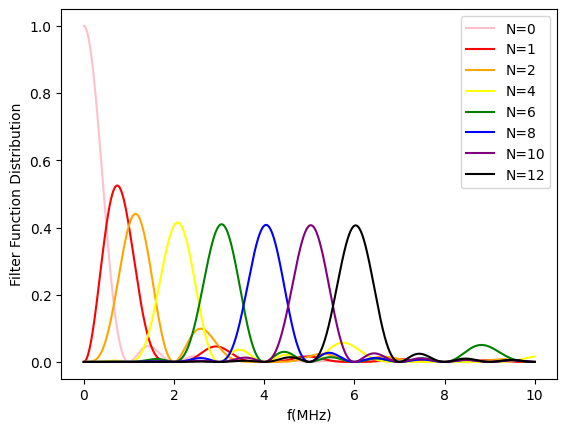

In [ ]:
tau = 1

fig, ax = plt.subplots(1, 1)
ax.plot(omega_list, filter(omega_list, tau, 0), label = 'N=0', color='pink')
ax.plot(omega_list, filter(omega_list, tau, 1), label = 'N=1', color='red')
ax.plot(omega_list, filter(omega_list, tau, 2), label = 'N=2', color='orange')
ax.plot(omega_list, filter(omega_list, tau, 4), label = 'N=4', color='yellow')
ax.plot(omega_list, filter(omega_list, tau, 6), label = 'N=6', color='green')
ax.plot(omega_list, filter(omega_list, tau, 8), label = 'N=8', color='blue')
ax.plot(omega_list, filter(omega_list, tau, 10), label = 'N=10', color='purple')
ax.plot(omega_list, filter(omega_list, tau, 12), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('f(MHz)')
ax.set_ylabel('Filter Function Distribution')

<ipython-input-14-09a753571ad5>:6: RuntimeWarning: invalid value encountered in divide
  f = (4*np.sin(2*np.pi*tau*omega_list/2)*np.sin(2*np.pi*tau*omega_list/2))/(2*np.pi*2*np.pi*omega_list**2)
<ipython-input-14-09a753571ad5>:10: RuntimeWarning: invalid value encountered in divide
  f = ((4*np.sin(2*np.pi*tau*omega_list/4)*np.sin(2*np.pi*tau*omega_list/4))/(2*np.pi*omega_list))**2
<ipython-input-14-09a753571ad5>:14: RuntimeWarning: invalid value encountered in divide
  f = (2*np.sin(2*np.pi*tau*omega_list/2)*(np.cos(2*np.pi*tau*omega_list/(2*N))-1)/(2*np.pi*omega_list*np.cos(2*np.pi*tau*omega_list/(2*N))))**2


Text(0, 0.5, 'Filter Function Distribution')

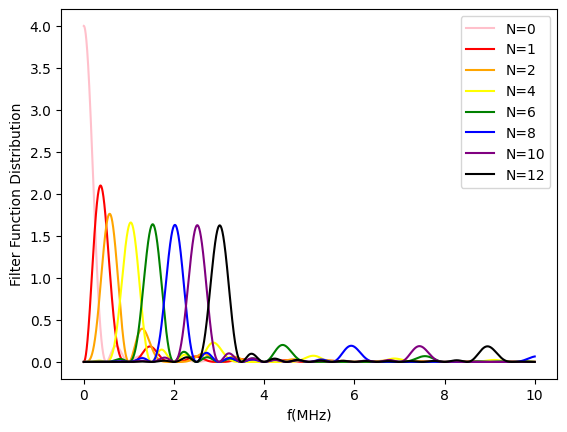

In [ ]:
tau = 2

fig, ax = plt.subplots(1, 1)
ax.plot(omega_list, filter(omega_list, tau, 0), label = 'N=0', color='pink')
ax.plot(omega_list, filter(omega_list, tau, 1), label = 'N=1', color='red')
ax.plot(omega_list, filter(omega_list, tau, 2), label = 'N=2', color='orange')
ax.plot(omega_list, filter(omega_list, tau, 4), label = 'N=4', color='yellow')
ax.plot(omega_list, filter(omega_list, tau, 6), label = 'N=6', color='green')
ax.plot(omega_list, filter(omega_list, tau, 8), label = 'N=8', color='blue')
ax.plot(omega_list, filter(omega_list, tau, 10), label = 'N=10', color='purple')
ax.plot(omega_list, filter(omega_list, tau, 12), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('f(MHz)')
ax.set_ylabel('Filter Function Distribution')

In [ ]:
def lorentzian(omega_list, kappa, n):
  return n*kappa/((2*np.pi*omega_list)**2 + (kappa/2)**2)

In [ ]:
def chi_N(tau, kappa, n, kai, N):
  freq_list = np.linspace(0.01,10000.01,1000000)
  filt = filter(freq_list, tau, N)
  spec = lorentzian(freq_list, kappa, n)
  A = 0
  for i in range(10000):
    A = A + 2*np.pi * 2*kai**2 * filt[i]*spec[i]*0.01

  return A

### $n = 0.01$

$\kappa = 2 \pi 10 MHz$

$ \tau = 1 \mu s $

Text(0, 0.5, 'chi_white(t)')

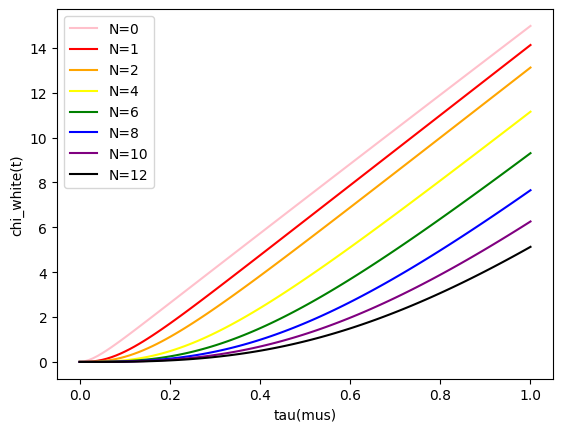

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1,100)

kappa = 2*np.pi*10
n = 0.01
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 0) for tau in range(100)]), label = 'N=0', color='pink')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 1) for tau in range(100)]), label = 'N=1', color='red')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)]), label = 'N=2', color='orange')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 4) for tau in range(100)]), label = 'N=4', color='yellow')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 6) for tau in range(100)]), label = 'N=6', color='green')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 8) for tau in range(100)]), label = 'N=8', color='blue')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 10) for tau in range(100)]), label = 'N=10', color='purple')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 12) for tau in range(100)]), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

Text(0, 0.5, 'chi_white(t)')

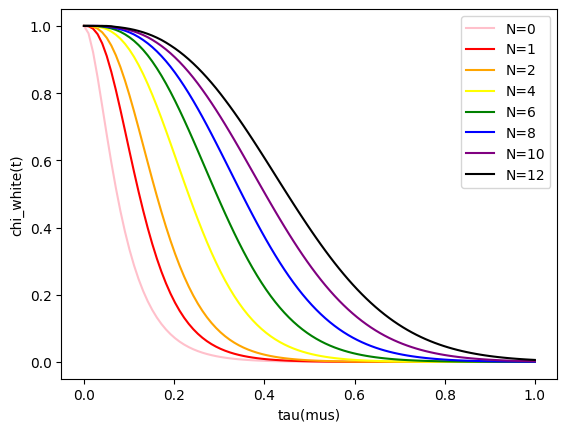

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1,100)

kappa = 2*np.pi*10
n = 0.01
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 0) for tau in range(100)])), label = 'N=0', color='pink')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 1) for tau in range(100)])), label = 'N=1', color='red')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)])), label = 'N=2', color='orange')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 4) for tau in range(100)])), label = 'N=4', color='yellow')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 6) for tau in range(100)])), label = 'N=6', color='green')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 8) for tau in range(100)])), label = 'N=8', color='blue')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 10) for tau in range(100)])), label = 'N=10', color='purple')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 12) for tau in range(100)])), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

### $n = 0.01$

$\kappa = 2 \pi 3 MHz$

$ \tau = 1 \mu s $

Text(0, 0.5, 'chi_white(t)')

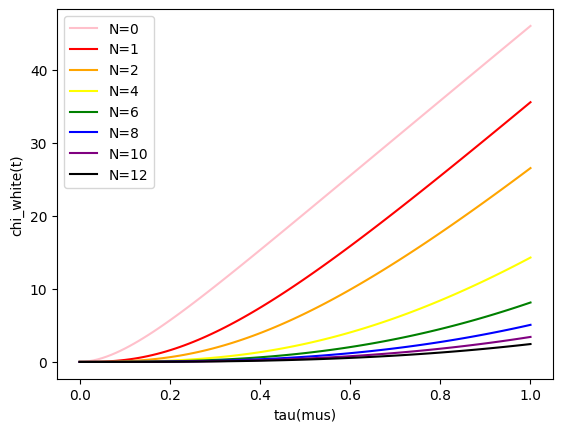

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1,100)

kappa = 2*np.pi*3
n = 0.01
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 0) for tau in range(100)]), label = 'N=0', color='pink')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 1) for tau in range(100)]), label = 'N=1', color='red')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)]), label = 'N=2', color='orange')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 4) for tau in range(100)]), label = 'N=4', color='yellow')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 6) for tau in range(100)]), label = 'N=6', color='green')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 8) for tau in range(100)]), label = 'N=8', color='blue')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 10) for tau in range(100)]), label = 'N=10', color='purple')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 12) for tau in range(100)]), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

Text(0, 0.5, 'chi_white(t)')

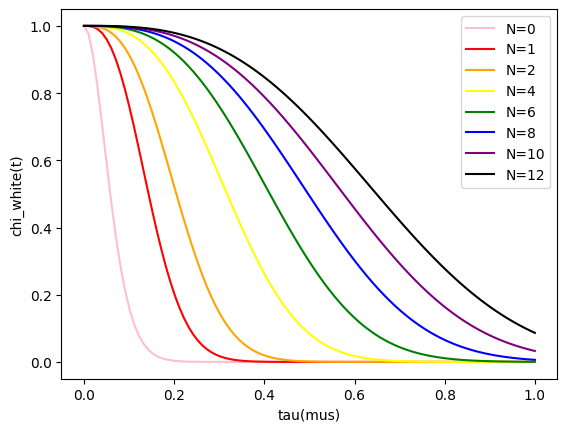

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1,100)

kappa = 2*np.pi*3
n = 0.01
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 0) for tau in range(100)])), label = 'N=0', color='pink')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 1) for tau in range(100)])), label = 'N=1', color='red')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)])), label = 'N=2', color='orange')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 4) for tau in range(100)])), label = 'N=4', color='yellow')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 6) for tau in range(100)])), label = 'N=6', color='green')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 8) for tau in range(100)])), label = 'N=8', color='blue')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 10) for tau in range(100)])), label = 'N=10', color='purple')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 12) for tau in range(100)])), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

### $n = 0.1$

$\kappa = 2 \pi 10 MHz$

$ \tau = 1 \mu s $

Text(0, 0.5, 'chi_white(t)')

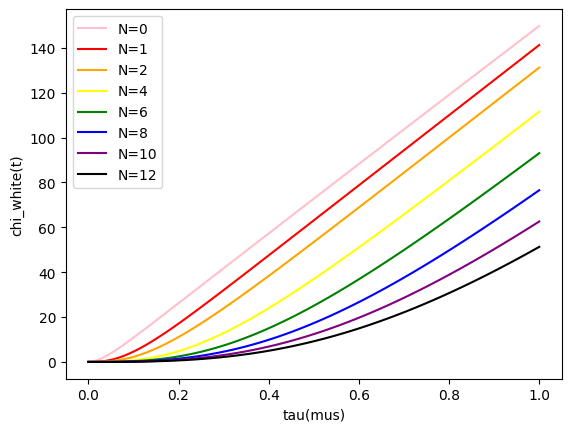

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1,100)

kappa = 2*np.pi*10
n = 0.1
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 0) for tau in range(100)]), label = 'N=0', color='pink')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 1) for tau in range(100)]), label = 'N=1', color='red')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)]), label = 'N=2', color='orange')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 4) for tau in range(100)]), label = 'N=4', color='yellow')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 6) for tau in range(100)]), label = 'N=6', color='green')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 8) for tau in range(100)]), label = 'N=8', color='blue')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 10) for tau in range(100)]), label = 'N=10', color='purple')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 12) for tau in range(100)]), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

Text(0, 0.5, 'chi_white(t)')

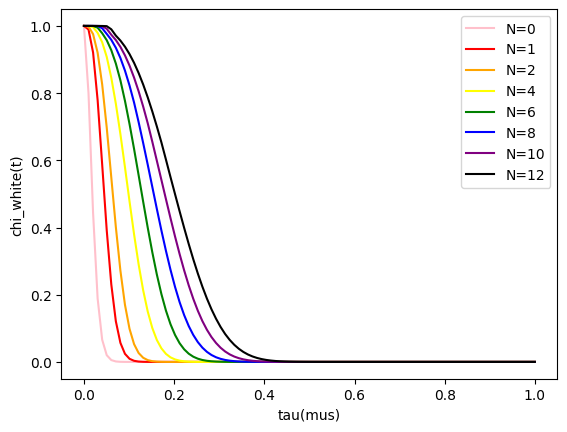

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1,100)

kappa = 2*np.pi*10
n = 0.1
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 0) for tau in range(100)])), label = 'N=0', color='pink')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 1) for tau in range(100)])), label = 'N=1', color='red')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)])), label = 'N=2', color='orange')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 4) for tau in range(100)])), label = 'N=4', color='yellow')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 6) for tau in range(100)])), label = 'N=6', color='green')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 8) for tau in range(100)])), label = 'N=8', color='blue')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 10) for tau in range(100)])), label = 'N=10', color='purple')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 12) for tau in range(100)])), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

### $n = 0.1$

$\kappa = 2 \pi 3 MHz$

$ \tau = 1 \mu s $

Text(0, 0.5, 'chi_white(t)')

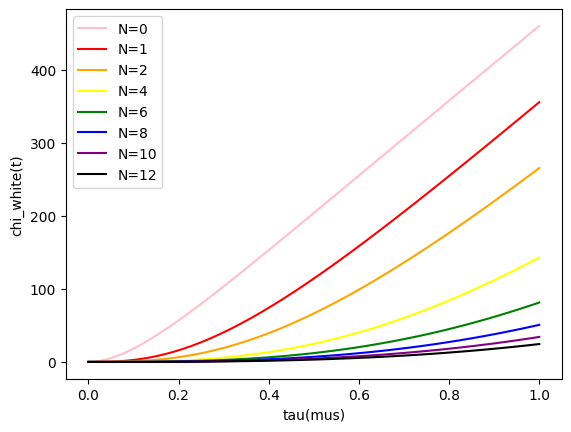

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1,100)

kappa = 2*np.pi*3
n = 0.1
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 0) for tau in range(100)]), label = 'N=0', color='pink')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 1) for tau in range(100)]), label = 'N=1', color='red')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)]), label = 'N=2', color='orange')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 4) for tau in range(100)]), label = 'N=4', color='yellow')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 6) for tau in range(100)]), label = 'N=6', color='green')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 8) for tau in range(100)]), label = 'N=8', color='blue')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 10) for tau in range(100)]), label = 'N=10', color='purple')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 12) for tau in range(100)]), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

Text(0, 0.5, 'chi_white(t)')

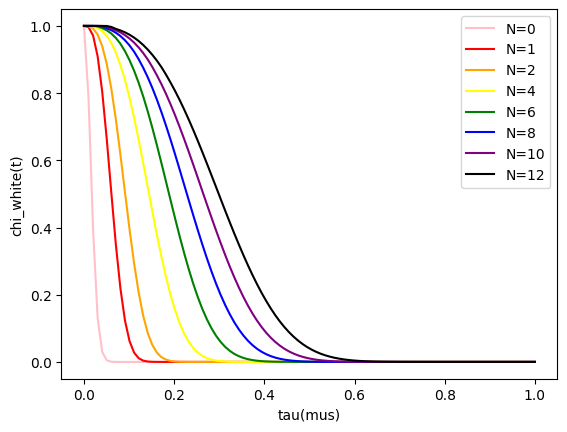

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1,100)

kappa = 2*np.pi*3
n = 0.1
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 0) for tau in range(100)])), label = 'N=0', color='pink')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 1) for tau in range(100)])), label = 'N=1', color='red')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)])), label = 'N=2', color='orange')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 4) for tau in range(100)])), label = 'N=4', color='yellow')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 6) for tau in range(100)])), label = 'N=6', color='green')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 8) for tau in range(100)])), label = 'N=8', color='blue')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 10) for tau in range(100)])), label = 'N=10', color='purple')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 12) for tau in range(100)])), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

### $n = 1$

$\kappa = 2 \pi 10 MHz$

$ \tau = 1 \mu s $

Text(0, 0.5, 'chi_white(t)')

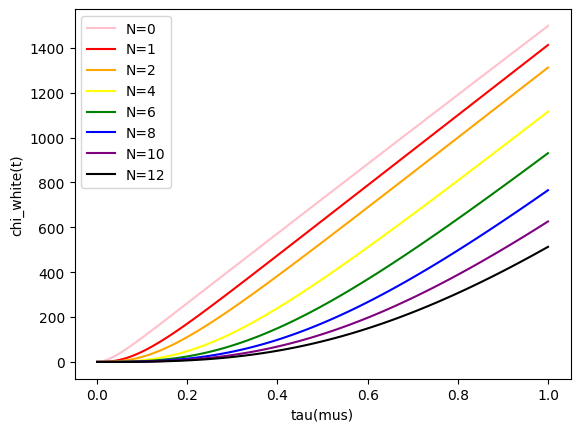

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1,100)

kappa = 2*np.pi*10
n = 1
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 0) for tau in range(100)]), label = 'N=0', color='pink')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 1) for tau in range(100)]), label = 'N=1', color='red')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)]), label = 'N=2', color='orange')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 4) for tau in range(100)]), label = 'N=4', color='yellow')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 6) for tau in range(100)]), label = 'N=6', color='green')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 8) for tau in range(100)]), label = 'N=8', color='blue')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 10) for tau in range(100)]), label = 'N=10', color='purple')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 12) for tau in range(100)]), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

Text(0, 0.5, 'chi_white(t)')

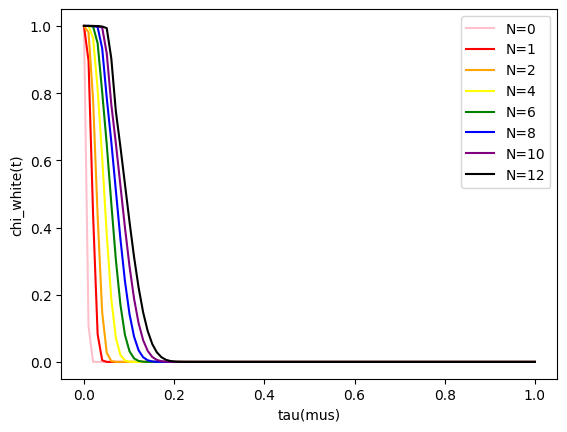

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1,100)

kappa = 2*np.pi*10
n = 1
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 0) for tau in range(100)])), label = 'N=0', color='pink')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 1) for tau in range(100)])), label = 'N=1', color='red')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)])), label = 'N=2', color='orange')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 4) for tau in range(100)])), label = 'N=4', color='yellow')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 6) for tau in range(100)])), label = 'N=6', color='green')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 8) for tau in range(100)])), label = 'N=8', color='blue')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 10) for tau in range(100)])), label = 'N=10', color='purple')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 12) for tau in range(100)])), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

### $n = 1$

$\kappa = 2 \pi 3 MHz$

$ \tau = 1 \mu s $

Text(0, 0.5, 'chi_white(t)')

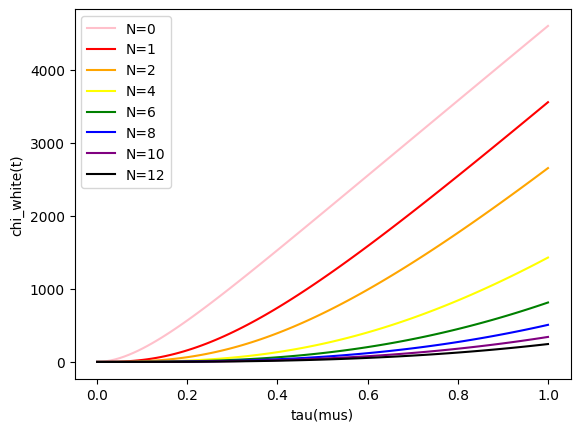

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1,100)

kappa = 2*np.pi*3
n = 1
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 0) for tau in range(100)]), label = 'N=0', color='pink')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 1) for tau in range(100)]), label = 'N=1', color='red')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)]), label = 'N=2', color='orange')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 4) for tau in range(100)]), label = 'N=4', color='yellow')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 6) for tau in range(100)]), label = 'N=6', color='green')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 8) for tau in range(100)]), label = 'N=8', color='blue')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 10) for tau in range(100)]), label = 'N=10', color='purple')
ax.plot(tau_list, np.array([chi_N(0.01*tau, kappa, n, kai, 12) for tau in range(100)]), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

Text(0, 0.5, 'chi_white(t)')

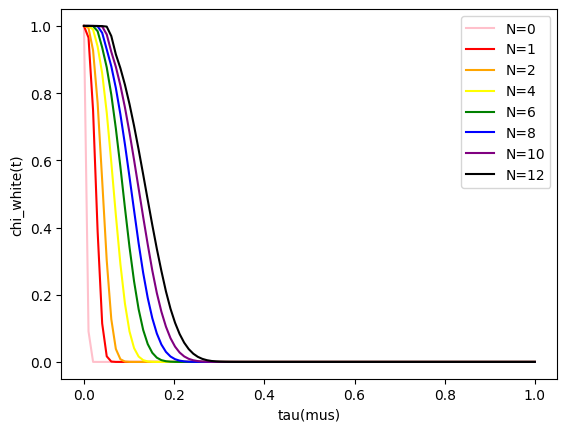

In [ ]:
# MHz Scale

tau_list = np.linspace(0,1,100)

kappa = 2*np.pi*3
n = 1
kai = 2*np.pi*10


fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 0) for tau in range(100)])), label = 'N=0', color='pink')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 1) for tau in range(100)])), label = 'N=1', color='red')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 2) for tau in range(100)])), label = 'N=2', color='orange')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 4) for tau in range(100)])), label = 'N=4', color='yellow')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 6) for tau in range(100)])), label = 'N=6', color='green')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 8) for tau in range(100)])), label = 'N=8', color='blue')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 10) for tau in range(100)])), label = 'N=10', color='purple')
ax.plot(tau_list, np.exp(-np.array([chi_N(0.01*tau, kappa, n, kai, 12) for tau in range(100)])), label = 'N=12', color='black')
ax.legend(loc = 0)
ax.set_xlabel('tau(mus)')
ax.set_ylabel('chi_white(t)')

## 2) Hamiltonian & Function Setting

Lab Frame

$H_0 = -\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + g\sigma_x(a+a^\dagger)$

$H_1 = A(t) (\hat{a} + \hat{a}^\dagger) \cos{(\omega_{rd} t)}$

$H_2 = B(t) \sigma_x \cos{(\omega_{qd} t)}$

Rotating Frame

$H_0 = -\frac{\omega_q-\omega_{qd}}{2}\sigma_z + ({\omega_r-\omega_{rd}})a^\dagger a + \chi\sigma_z(a^\dagger a)$

$H_1 = \frac{A(t)}{2} (\hat{a} + \hat{a}^\dagger) $

$H_2 = \frac{B(t)}{2}  \sigma_x $

In [7]:
# operator
N = 100

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

In [8]:
sz = sigmaz()
sx = sigmax()
sy = sigmay()

sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)

In [9]:
sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [10]:
H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())

H1 = 0.5*tensor(qeye(2), a + a.dag())

H2_x = 0.5*sx_composite

In [11]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-0.5*np.pi/A) * (t < T_cent+0.5*np.pi/A)

def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-0.5*np.pi/A) * (t < T_cent+0.5*np.pi/A)

In [12]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square

# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    return f(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

In [13]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [14]:
# time-dependent envelope for qubit drive (rotating frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hqd_rotating_frame(t, args):

    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    Env = args['Env']
    Func = args['Func']

    B = args['B']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    f = Hrd_env(Env, 0)
    pulse = f(t, {'A': B}, T_srt)

    for T_cent in Seq:
      f = Hrd_env(Env, 1)
      pulse = pulse + f(t, {'A': B}, T_cent)

    f = Hrd_env(Env, 0)
    pulse = pulse + f(t, {'A': B}, T_end)

    return pulse

In [15]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)

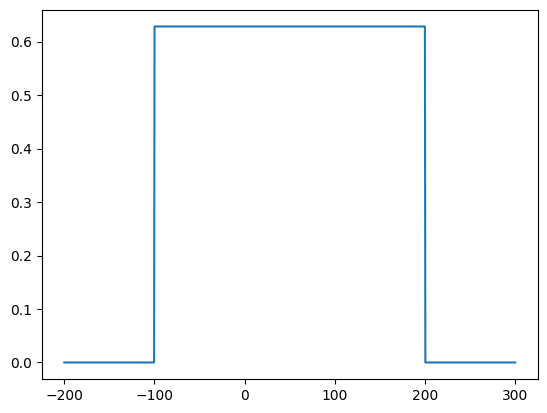

In [16]:
# resonator pulse simulation (rotating frame)
tlist = np.linspace(-200, 300, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*0.1, 'T_srt_r': -100, 'T_end_r': 200}))

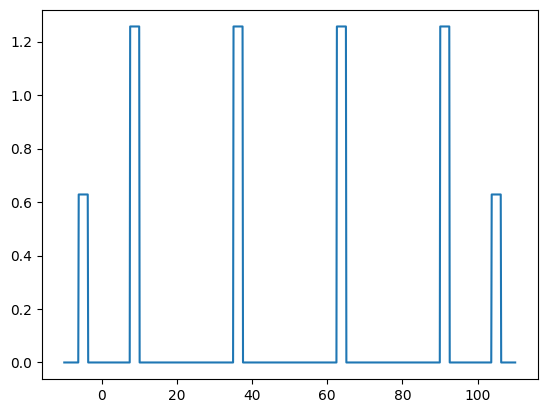

In [17]:
# qubit pulse simulation (rotating frame)
tlist = np.linspace(-10, 110, 1000)
plt.figure()
plt.plot(tlist, Hqd_rotating_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': -5, 'T_end_q': 105, 'N_seq': 4, 'Env': 0, 'Func': 0}))

## 3) DD $n$=0.004

$\kappa = 2\pi0.002, 2\pi0.004, 2\pi0.006, 2\pi0.008, 2\pi0.010, 2\pi0.012, 2\pi0.014$

$N = 0, 1, 2, 4, 6, 8, 10$


In [ ]:
A = [0.00126,0.00129,0.00135,0.00138,0.00142,0.00153,0.00153]
alpha = [-0.0062j,-0.0124j,-0.01857j,-0.02379j,-0.0284j,-0.0337j,-0.03594j]
kappa_seq = [0.006,0.008,0.010,0.012,0.014]
N_seq = [0,1,2,4,6,8,10]
tau_list = [50*(k+2) for k in range(19)]
n_exp = 0.004

z_tot = []
plus_tot = []

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0 # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz

kai = g*g/(omega_r-omega_q)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite]

In [ ]:
# iterate for kappa
for i in range(5):

  kappa = 2*np.pi*kappa_seq[i]

  psi_20 = tensor(basis(2,0), basis(N,0))
  psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), coherent(N, alpha[i]))
  psi_21 = tensor(basis(2,1), basis(N,0))

  H0 = -n_exp*kai*sz_composite + (kappa)*number_composite + kai*tensor(sz, a.dag()*a)
  H1 = 0.5*tensor(qeye(2), a + a.dag())
  H2 = 0.5*sx_composite

  z_n = []
  plus_n = []


  # iterate for pi-pulse time N
  for j in range(7):

    z = []
    plus = []


    # iterate for evolution time 100ns ~ 1000ns
    for k in range(19):

      # Simulation
      tlist = np.linspace(0, 50*(k+2), 500*(k+2))

      result = mesolve(
        [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
        psi_2s,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
        e_ops = op_list,
        options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
      )

      x_sub = result.expect[0]
      y_sub = result.expect[1]
      z_sub = result.expect[2]
      plus_sub = result.expect[3]

      z.append(z_sub[-1])
      plus.append(np.abs(2*plus_sub[-1]))

    z_n.append(z)
    plus_n.append(plus)

  z_tot.append(z_n)
  plus_tot.append(plus_n)

  print(i)

/usr/local/lib/python3.10/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


0
1
2
3
4


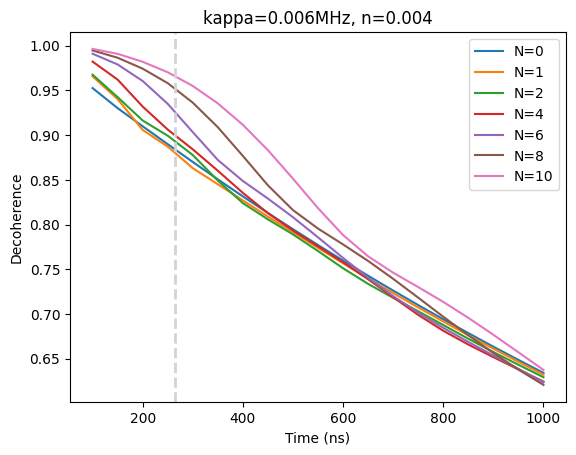

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[0][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[0], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')
plt.axvline(10/(2*np.pi*kappa_seq[0]), 0, 1.0, color='lightgray', linestyle='--', linewidth=2)

Text(0, 0.5, 'Z')

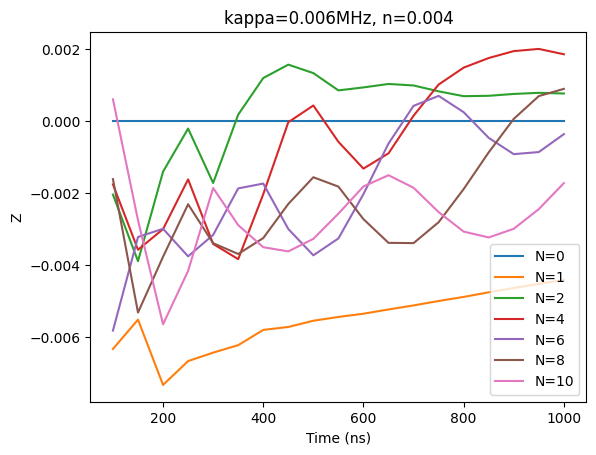

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[0][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[0], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

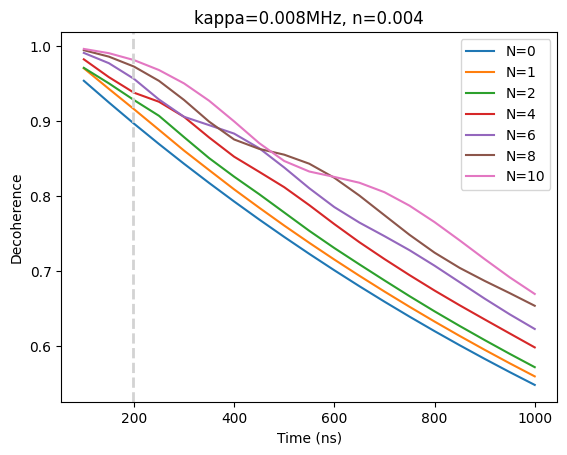

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[1][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[1], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')
plt.axvline(10/(2*np.pi*kappa_seq[1]), 0, 1.0, color='lightgray', linestyle='--', linewidth=2)

Text(0, 0.5, 'Z')

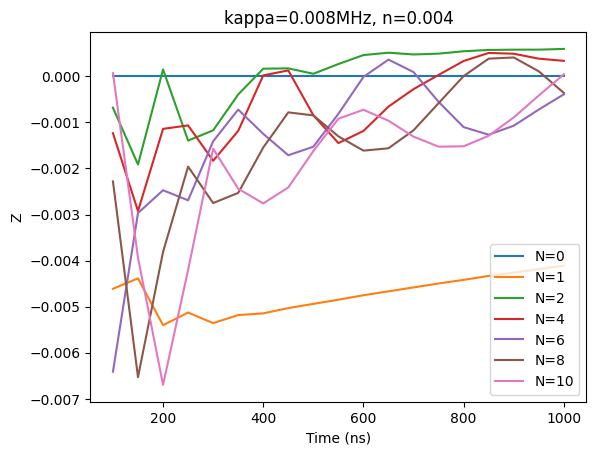

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[1][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[1], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

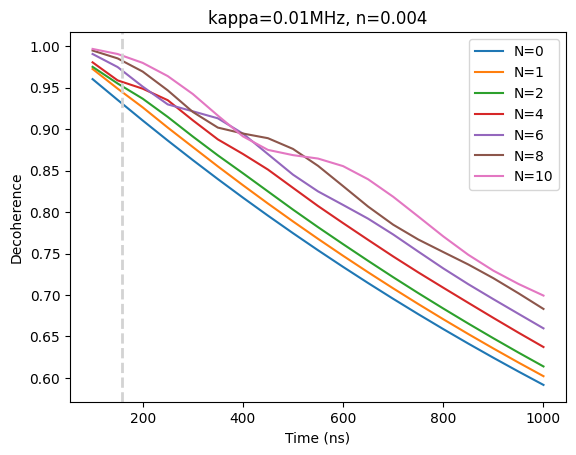

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[2][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[2], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')
plt.axvline(10/(2*np.pi*kappa_seq[2]), 0, 1.0, color='lightgray', linestyle='--', linewidth=2)

Text(0, 0.5, 'Z')

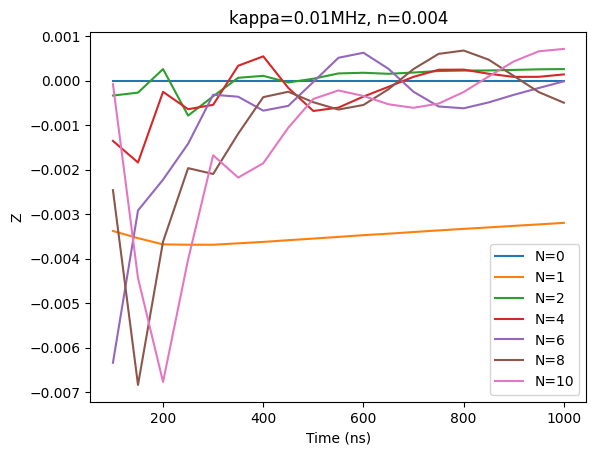

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[2][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[2], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

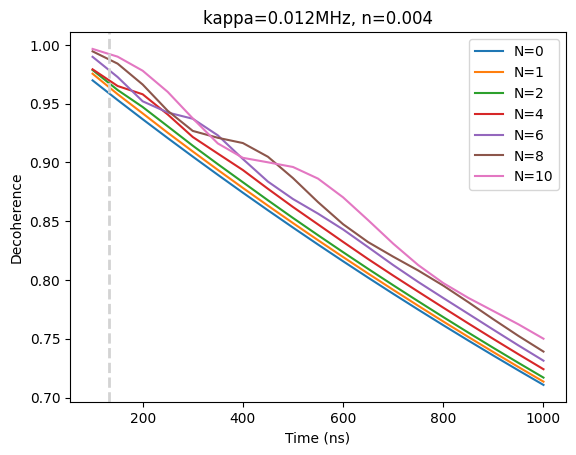

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[3][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[3], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')
plt.axvline(10/(2*np.pi*kappa_seq[3]), 0, 1.0, color='lightgray', linestyle='--', linewidth=2)

Text(0, 0.5, 'Z')

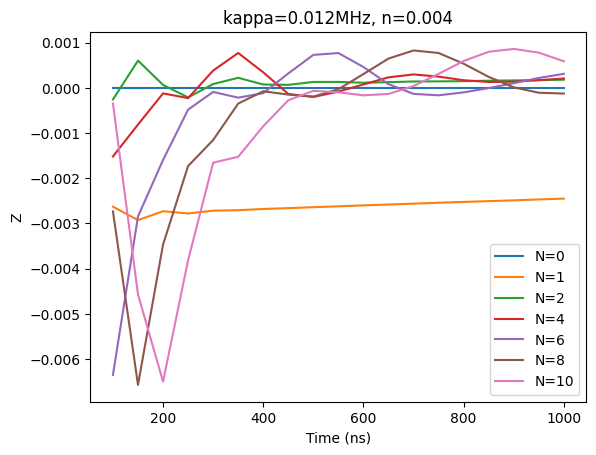

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[3][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[3], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

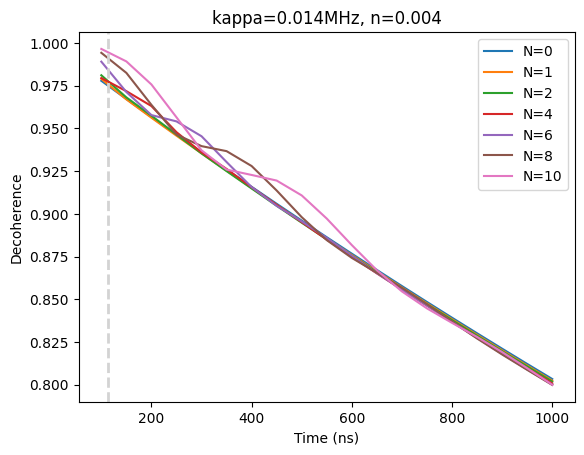

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[4][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[4], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')
plt.axvline(10/(2*np.pi*kappa_seq[4]), 0, 1.0, color='lightgray', linestyle='--', linewidth=2)

Text(0, 0.5, 'Z')

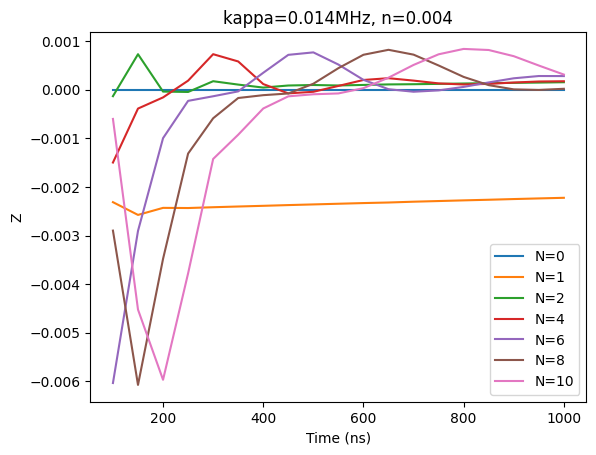

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[4][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[4], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

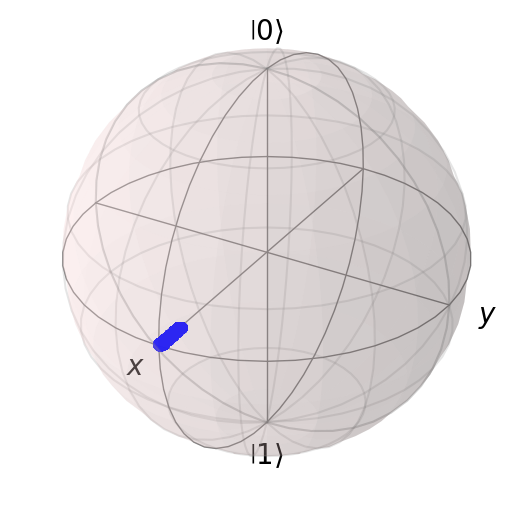

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## 4) $n$=0.004 Dynamical Decoupling Estimation

In [ ]:
# tau = 300ns
off_300 = []
for i in range(5):
  lst = []

  for j in range(7):
    lst.append(plus_tot[i][j][4])

  off_300.append(lst)

off_300

[[0.8700117690970675,
  0.8631048094053513,
  0.8777819735129,
  0.8841262290087273,
  0.903416798289006,
  0.9363454459202822,
  0.9549985220240923],
 [0.8435188629767939,
  0.861103600363148,
  0.8790731691303693,
  0.906139702672439,
  0.9061961434593675,
  0.9286723474810148,
  0.9507599621145323],
 [0.8626888524198493,
  0.8784193828082021,
  0.8910720509800835,
  0.9106562248316604,
  0.9214772838489109,
  0.9207336943422552,
  0.9423300782653832],
 [0.9049953908550519,
  0.9093657490300882,
  0.9142710570344453,
  0.9216631333949996,
  0.9371913536229601,
  0.9268626735968399,
  0.9374997004773988],
 [0.9359925961787458,
  0.935384600426879,
  0.9353240489019755,
  0.9359622270268799,
  0.9453806424119106,
  0.9395932324434372,
  0.9371431338040176]]

In [ ]:
# tau = 300ns, KHz
gamma_300 = []
for i in range(5):
  lst = []

  for j in range(7):
    lst.append(-(1000000/300)*np.log(plus_tot[i][j][4]))

  gamma_300.append(lst)

gamma_300

[[464.16179909075817,
  490.73049175416185,
  434.5234597442082,
  410.51811180715094,
  338.570871383033,
  219.23601479519402,
  153.48495373785298],
 [567.2433816650431,
  498.46818722642286,
  429.62381143283113,
  328.5392920537599,
  328.33167495355127,
  246.66432052180227,
  168.31218021516216],
 [492.3373157245189,
  432.1038081061363,
  384.4332982774579,
  311.966043897201,
  272.59051150794534,
  275.28144306009216,
  197.9988807548449],
 [332.75142757674473,
  316.6930052063316,
  298.7606339558877,
  271.9182908965736,
  216.22599381823755,
  253.16621687476055,
  215.1294687613226],
 [220.49237533757437,
  222.65832304839,
  222.8741112380558,
  220.60053019790908,
  187.22545461975892,
  207.69409605503242,
  216.39750293885837]]

In [ ]:
# tau = 300ns
gamma_2_300 = []
for i in range(5):
  lst = []

  for j in range(7):
    lst.append(gamma_300[i][j]-0.5*kappa_seq[i]*1000000*0.01)

  gamma_2_300.append(lst)

gamma_2_300

[[434.16179909075817,
  460.73049175416185,
  404.5234597442082,
  380.51811180715094,
  308.570871383033,
  189.23601479519402,
  123.48495373785298],
 [527.2433816650431,
  458.46818722642286,
  389.62381143283113,
  288.5392920537599,
  288.33167495355127,
  206.66432052180227,
  128.31218021516216],
 [442.3373157245189,
  382.1038081061363,
  334.4332982774579,
  261.966043897201,
  222.59051150794534,
  225.28144306009216,
  147.9988807548449],
 [272.75142757674473,
  256.6930052063316,
  238.76063395588773,
  211.91829089657358,
  156.22599381823755,
  193.16621687476055,
  155.1294687613226],
 [150.49237533757437,
  152.65832304839,
  152.8741112380558,
  150.60053019790908,
  117.22545461975892,
  137.69409605503242,
  146.39750293885837]]

In [ ]:
# tau = 1000ns
off_1000 = []
for i in range(5):
  lst = []

  for j in range(7):
    lst.append(plus_tot[i][j][18])

  off_1000.append(lst)

off_1000

[[0.6341322419303237,
  0.6321285168290107,
  0.6292586008815629,
  0.6243795542452619,
  0.6234215870603291,
  0.620673718882319,
  0.6374632439767115],
 [0.548421696686909,
  0.5598337594115858,
  0.5721017796456163,
  0.5984928099088281,
  0.6230720208949088,
  0.6540311330033588,
  0.6698079660175754],
 [0.5916068864503474,
  0.6021319787882856,
  0.6138725422961541,
  0.6372853161855248,
  0.6598068090508259,
  0.6832077111254485,
  0.6993046508605099],
 [0.7107457834195766,
  0.713522065230759,
  0.7169722770889025,
  0.7241052318628429,
  0.7313645481533343,
  0.7391091563406469,
  0.750071891346419],
 [0.8033535631673523,
  0.8023971283974762,
  0.8018588566786857,
  0.8008094187947736,
  0.8000252002513857,
  0.7998919443892719,
  0.7999781959173395]]

In [ ]:
# tau = 1000ns, KHz
gamma_1000 = []
for i in range(5):
  lst = []

  for j in range(7):
    lst.append(-(1000000/1000)*np.log(plus_tot[i][j][18]))

  gamma_1000.append(lst)

gamma_1000

[[455.49776280910703,
  458.6625560949774,
  463.2129765951853,
  470.99683551941524,
  472.5322843043703,
  476.9497475539628,
  450.25866011887535],
 [600.7107684607892,
  580.1153975176547,
  558.4383669877653,
  513.3407675753563,
  473.09316351362327,
  424.60032467730093,
  400.7642255640971],
 [524.9129078306389,
  507.2786238339645,
  487.96795822079923,
  450.53781759024304,
  415.8082003699963,
  380.9563497953472,
  357.6687935572521],
 [341.4404610474838,
  337.54191720248684,
  332.71810427800693,
  322.818549281545,
  312.8432456566436,
  302.3096607676311,
  287.5862219170315],
 [218.9603591166178,
  220.15162110766923,
  220.82267578223133,
  222.13228931855954,
  223.11205149610214,
  223.27862995032808,
  223.1708067889624]]

In [ ]:
# tau = 1000ns
gamma_2_1000 = []
for i in range(5):
  lst = []

  for j in range(7):
    lst.append(gamma_1000[i][j]-0.5*kappa_seq[i]*1000000*0.01)

  gamma_2_1000.append(lst)

gamma_2_1000

[[425.49776280910703,
  428.6625560949774,
  433.2129765951853,
  440.99683551941524,
  442.5322843043703,
  446.9497475539628,
  420.25866011887535],
 [560.7107684607892,
  540.1153975176547,
  518.4383669877653,
  473.34076757535627,
  433.09316351362327,
  384.60032467730093,
  360.7642255640971],
 [474.9129078306389,
  457.2786238339645,
  437.96795822079923,
  400.53781759024304,
  365.8082003699963,
  330.9563497953472,
  307.6687935572521],
 [281.4404610474838,
  277.54191720248684,
  272.71810427800693,
  262.818549281545,
  252.8432456566436,
  242.3096607676311,
  227.58622191703148],
 [148.9603591166178,
  150.15162110766923,
  150.82267578223133,
  152.13228931855954,
  153.11205149610214,
  153.27862995032808,
  153.1708067889624]]

## 5) DD $n$=0.01

$\kappa = 2\pi0.002, 2\pi0.004, 2\pi0.006, 2\pi0.008, 2\pi0.010, 2\pi0.012, 2\pi0.014$

$N = 0, 1, 2, 4, 6, 8, 10$


In [18]:
A = [0.00201,0.00201,0.00207,0.00213,0.00224,0.00234,0.00244]
alpha = [-0.0099j,-0.0193j,-0.02848j,-0.03672j,-0.0448j,-0.051617j,-0.0573j]
kappa_seq = [0.006,0.008,0.010,0.012,0.014]
N_seq = [0,1,2,4,6,8,10]
tau_list = [50*(k+2) for k in range(19)]
n_exp = 0.01

z_tot = []
plus_tot = []

In [19]:
N = 5

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0 # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz

kai = g*g/(omega_r-omega_q)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite]

In [20]:
# iterate for kappa
for i in range(5):

  kappa = 2*np.pi*kappa_seq[i]

  psi_20 = tensor(basis(2,0), basis(N,0))
  psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), coherent(N, alpha[i]))
  psi_21 = tensor(basis(2,1), basis(N,0))

  H0 = -n_exp*kai*sz_composite + (kappa)*number_composite + kai*tensor(sz, a.dag()*a)
  H1 = 0.5*tensor(qeye(2), a + a.dag())
  H2 = 0.5*sx_composite

  z_n = []
  plus_n = []


  # iterate for pi-pulse time N
  for j in range(7):

    z = []
    plus = []


    # iterate for evolution time 100ns ~ 1000ns
    for k in range(19):

      # Simulation
      tlist = np.linspace(0, 50*(k+2), 500*(k+2))

      result = mesolve(
        [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
        psi_2s,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
        e_ops = op_list,
        options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
      )

      x_sub = result.expect[0]
      y_sub = result.expect[1]
      z_sub = result.expect[2]
      plus_sub = result.expect[3]

      z.append(z_sub[-1])
      plus.append(np.abs(2*plus_sub[-1]))

    z_n.append(z)
    plus_n.append(plus)

  z_tot.append(z_n)
  plus_tot.append(plus_n)

  print(i)

/usr/local/lib/python3.10/dist-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


0
1
2
3
4


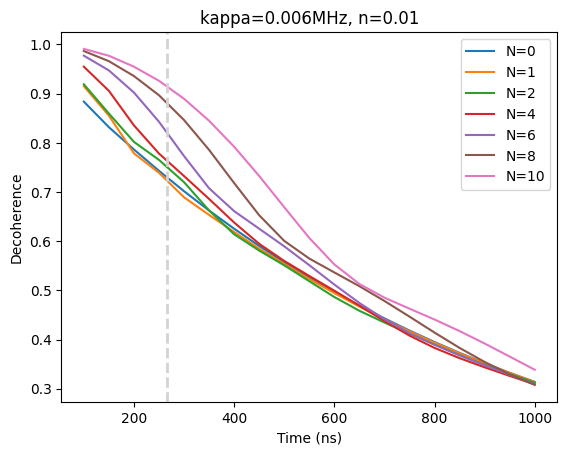

In [21]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[0][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[0], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')
plt.axvline(10/(2*np.pi*kappa_seq[0]), 0, 1.0, color='lightgray', linestyle='--', linewidth=2)

Text(0, 0.5, 'Z')

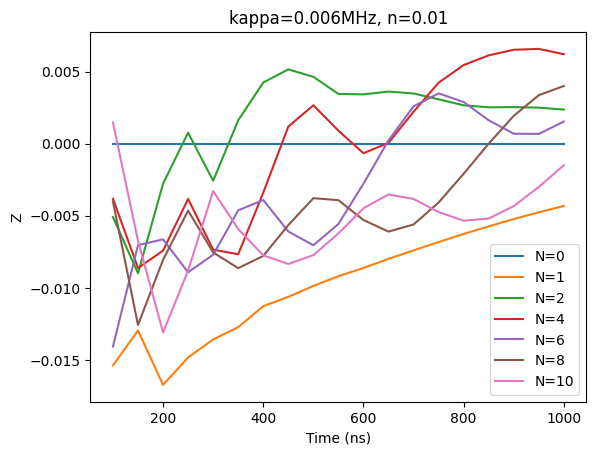

In [22]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[0][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[0], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

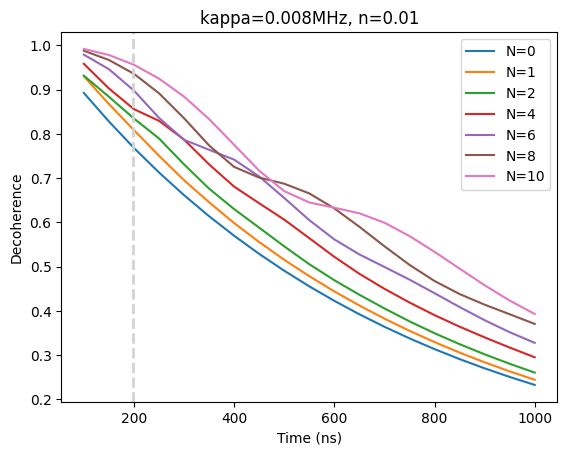

In [23]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[1][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[1], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')
plt.axvline(10/(2*np.pi*kappa_seq[1]), 0, 1.0, color='lightgray', linestyle='--', linewidth=2)

Text(0, 0.5, 'Z')

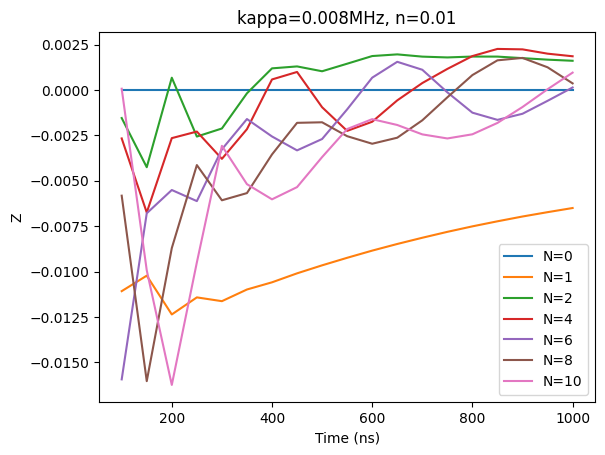

In [24]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[1][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[1], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

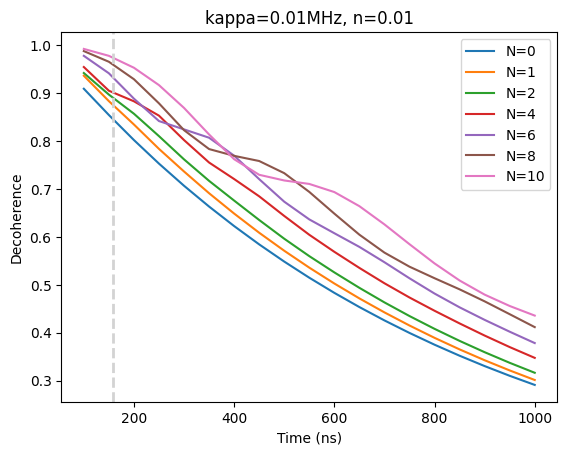

In [25]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[2][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[2], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')
plt.axvline(10/(2*np.pi*kappa_seq[2]), 0, 1.0, color='lightgray', linestyle='--', linewidth=2)

Text(0, 0.5, 'Z')

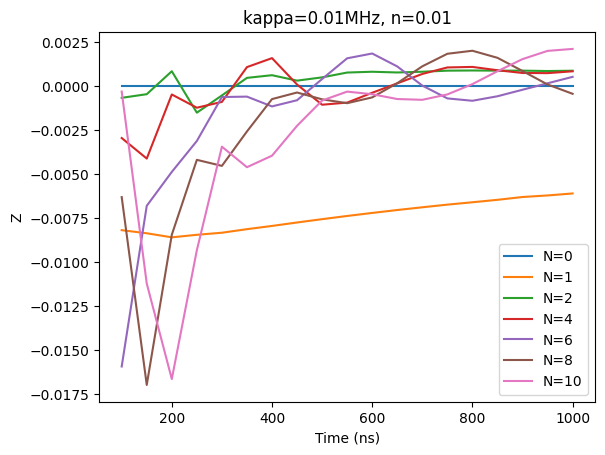

In [26]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[2][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[2], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

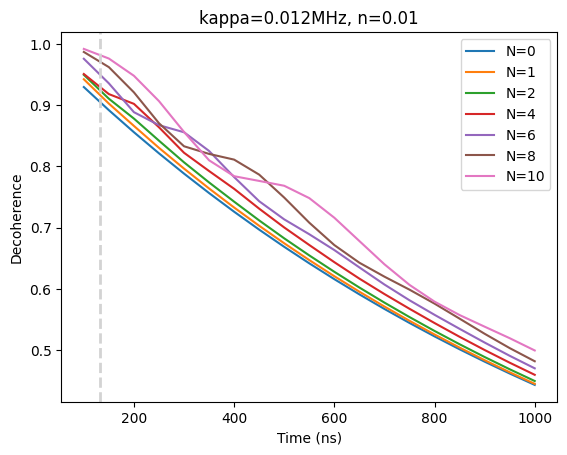

In [27]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[3][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[3], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')
plt.axvline(10/(2*np.pi*kappa_seq[3]), 0, 1.0, color='lightgray', linestyle='--', linewidth=2)

Text(0, 0.5, 'Z')

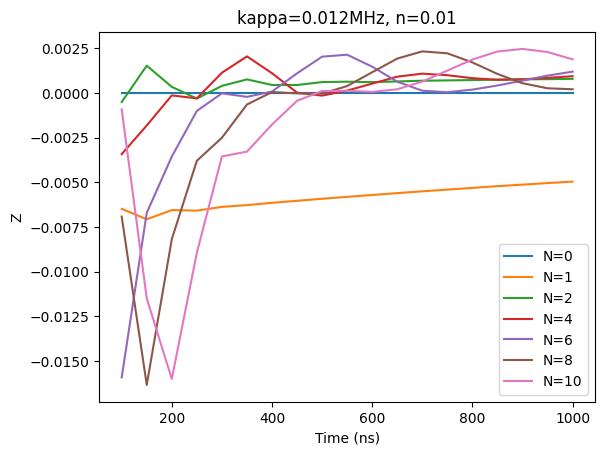

In [28]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[3][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[3], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

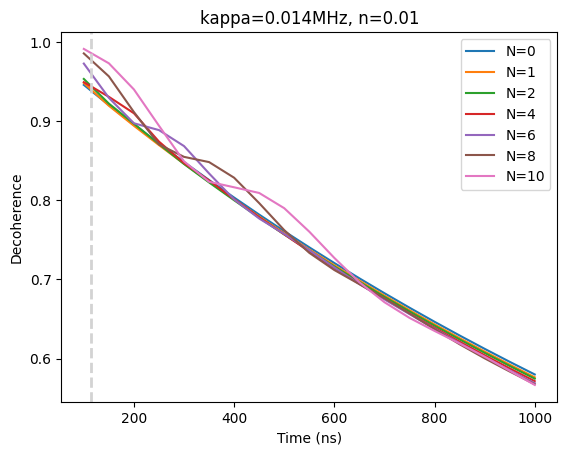

In [29]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[4][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[4], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')
plt.axvline(10/(2*np.pi*kappa_seq[4]), 0, 1.0, color='lightgray', linestyle='--', linewidth=2)

Text(0, 0.5, 'Z')

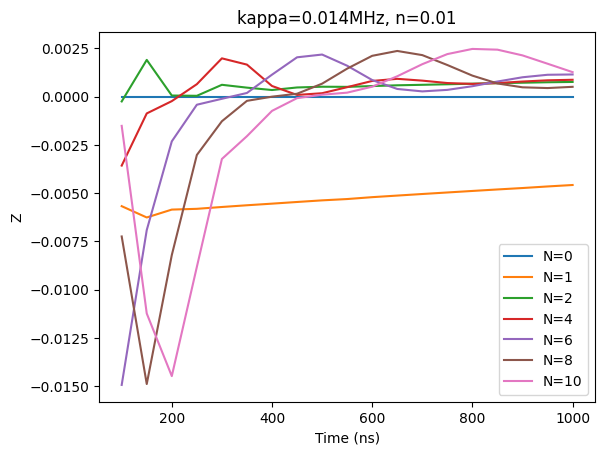

In [30]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[4][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[4], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

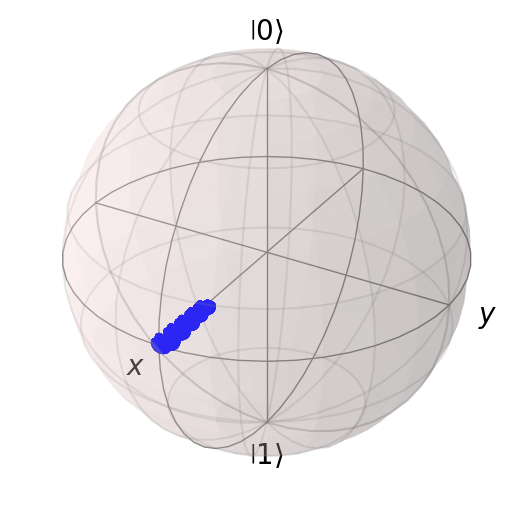

In [31]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## 6) $n$=0.01 Dynamical Decoupling Estimation

In [32]:
# tau = 300ns
off_300 = []
for i in range(5):
  lst = []

  for j in range(7):
    lst.append(plus_tot[i][j][4])

  off_300.append(lst)

off_300

[[0.7016227551118738,
  0.6891926830378631,
  0.7200097528248282,
  0.7324326330969807,
  0.7731064283257277,
  0.8463447115962492,
  0.8896381938687979],
 [0.6615695317913717,
  0.6953787688124559,
  0.7311583314060448,
  0.7871825763756652,
  0.7867288831992195,
  0.8354943841105809,
  0.8843703182630425],
 [0.7066191902214086,
  0.7363930524048059,
  0.7617040976018897,
  0.8019644972043671,
  0.8242445938584924,
  0.8226310895758219,
  0.8690380379753186],
 [0.7883471511850476,
  0.7965443105834172,
  0.8067525130022384,
  0.8223734651055704,
  0.8558620784994375,
  0.832991668385698,
  0.8563582018279203],
 [0.8482315321475398,
  0.8461508348987891,
  0.8457851677513253,
  0.8469708738744548,
  0.8684306064056112,
  0.8548102198413633,
  0.8491044102995096]]

In [33]:
# tau = 300ns, KHz
gamma_300 = []
for i in range(5):
  lst = []

  for j in range(7):
    lst.append(-(1000000/300)*np.log(plus_tot[i][j][4]))

  gamma_300.append(lst)

gamma_300

[[1181.1980176013005,
  1240.7813032892498,
  1094.968404912459,
  1037.9463692951977,
  857.7951923042544,
  556.0951394991537,
  389.80140884017686],
 [1377.133962145327,
  1210.9953025799975,
  1043.7508235170046,
  797.6502238605703,
  799.5719464845969,
  599.1055085348153,
  409.59797333796485],
 [1157.5446196335372,
  1019.9708806921192,
  907.3237402321016,
  735.6364664015009,
  644.2931863773482,
  650.8247653955648,
  467.89460850406584],
 [792.7224631584428,
  758.2417318727212,
  715.7944436156026,
  651.8688333147063,
  518.8201302348689,
  609.1054626775053,
  516.8884343035003],
 [548.6721575471983,
  556.8588114182505,
  558.2996348401939,
  553.6299077289356,
  470.2253233495576,
  522.9193326036526,
  545.2437330100946]]

In [34]:
# tau = 300ns
gamma_2_300 = []
for i in range(5):
  lst = []

  for j in range(7):
    lst.append(gamma_300[i][j]-0.5*kappa_seq[i]*1000000*0.01)

  gamma_2_300.append(lst)

gamma_2_300

[[1151.1980176013005,
  1210.7813032892498,
  1064.968404912459,
  1007.9463692951977,
  827.7951923042544,
  526.0951394991537,
  359.80140884017686],
 [1337.133962145327,
  1170.9953025799975,
  1003.7508235170046,
  757.6502238605703,
  759.5719464845969,
  559.1055085348153,
  369.59797333796485],
 [1107.5446196335372,
  969.9708806921192,
  857.3237402321016,
  685.6364664015009,
  594.2931863773482,
  600.8247653955648,
  417.89460850406584],
 [732.7224631584428,
  698.2417318727212,
  655.7944436156026,
  591.8688333147063,
  458.8201302348689,
  549.1054626775053,
  456.8884343035003],
 [478.67215754719825,
  486.8588114182505,
  488.2996348401939,
  483.62990772893556,
  400.2253233495576,
  452.9193326036526,
  475.2437330100946]]

In [35]:
# tau = 1000ns
off_1000 = []
for i in range(5):
  lst = []

  for j in range(7):
    lst.append(plus_tot[i][j][18])

  off_1000.append(lst)

off_1000

[[0.3137541809789011,
  0.3136641741056753,
  0.3122669206102368,
  0.30895459618287696,
  0.3093406008174297,
  0.30766812136680577,
  0.33848838851938867],
 [0.23260829918241918,
  0.24425926830232703,
  0.2604904030470225,
  0.295086202979237,
  0.32764901341934916,
  0.37047170596763357,
  0.3929978531438327],
 [0.2910878574974702,
  0.30137779582523194,
  0.31642946311805814,
  0.34753305203461365,
  0.3784182016077997,
  0.41168986104354216,
  0.43573879920385455],
 [0.44333823569343406,
  0.44509981049904657,
  0.4497226810582872,
  0.4598350895137191,
  0.4704220086744323,
  0.48197425550504264,
  0.49959432775187634],
 [0.5799230271934075,
  0.576344180691204,
  0.5745870277702416,
  0.5714544291016049,
  0.5688922315330394,
  0.5675067986927166,
  0.566695084513296]]

In [36]:
# tau = 1000ns, KHz
gamma_1000 = []
for i in range(5):
  lst = []

  for j in range(7):
    lst.append(-(1000000/1000)*np.log(plus_tot[i][j][18]))

  gamma_1000.append(lst)

gamma_1000

[[1159.1454627957644,
  1159.432374624575,
  1163.896942140436,
  1174.5609508003174,
  1173.3123411181632,
  1178.7336049891062,
  1083.2654899673812],
 [1458.3993594720998,
  1409.5250428126365,
  1345.189258977814,
  1220.4877518394244,
  1115.8123245820461,
  992.9782043209991,
  933.9511298661358],
 [1234.1301415791813,
  1199.3906656255097,
  1150.6549275818656,
  1056.8955047316456,
  971.7553414607262,
  887.4849775594629,
  830.7122995506909],
 [813.4222885404716,
  809.4567287095842,
  799.1241505015932,
  776.8873548329955,
  754.1250963441765,
  729.8645781732628,
  693.9588543742774],
 [544.859895984158,
  551.0502608175211,
  554.103708796488,
  559.5705380314064,
  564.0642625603944,
  566.5025496230684,
  567.9338897222549]]

In [37]:
# tau = 1000ns
gamma_2_1000 = []
for i in range(5):
  lst = []

  for j in range(7):
    lst.append(gamma_1000[i][j]-0.5*kappa_seq[i]*1000000*0.01)

  gamma_2_1000.append(lst)

gamma_2_1000

[[1129.1454627957644,
  1129.432374624575,
  1133.896942140436,
  1144.5609508003174,
  1143.3123411181632,
  1148.7336049891062,
  1053.2654899673812],
 [1418.3993594720998,
  1369.5250428126365,
  1305.189258977814,
  1180.4877518394244,
  1075.8123245820461,
  952.9782043209991,
  893.9511298661358],
 [1184.1301415791813,
  1149.3906656255097,
  1100.6549275818656,
  1006.8955047316456,
  921.7553414607262,
  837.4849775594629,
  780.7122995506909],
 [753.4222885404716,
  749.4567287095842,
  739.1241505015932,
  716.8873548329955,
  694.1250963441765,
  669.8645781732628,
  633.9588543742774],
 [474.859895984158,
  481.0502608175211,
  484.10370879648804,
  489.5705380314064,
  494.06426256039435,
  496.5025496230684,
  497.9338897222549]]

## 7) DD $n$=0.04

$\kappa = 2\pi0.002, 2\pi0.004, 2\pi0.006, 2\pi0.008, 2\pi0.010, 2\pi0.012, 2\pi0.014$

$N = 0, 1, 2, 4, 6, 8, 10$


In [ ]:
A = [0.00402,0.00405,0.00414,0.00429,0.00447,0.00457,0.00482]
alpha = [-0.0198j,-0.0894j,-0.05697j,-0.07396j,-0.0894j,-0.1008j,-0.1132j]
kappa_seq = [0.002,0.004,0.006,0.008,0.010,0.012,0.014]
N_seq = [0,1,2,4,6,8,10]
tau_list = [50*(k+2) for k in range(19)]
n_exp = 0.04

z_tot = []
plus_tot = []

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0 # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz

kai = g*g/(omega_r-omega_q)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite]

In [ ]:
# iterate for kappa
for i in range(5):

  kappa = 2*np.pi*kappa_seq[i]

  psi_20 = tensor(basis(2,0), basis(N,0))
  psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), coherent(N, alpha[i]))
  psi_21 = tensor(basis(2,1), basis(N,0))

  H0 = -n_exp*kai*sz_composite + (kappa)*number_composite + kai*tensor(sz, a.dag()*a)
  H1 = 0.5*tensor(qeye(2), a + a.dag())
  H2 = 0.5*sx_composite

  z_n = []
  plus_n = []


  # iterate for pi-pulse time N
  for j in range(7):

    z = []
    plus = []


    # iterate for evolution time 100ns ~ 1000ns
    for k in range(19):

      # Simulation
      tlist = np.linspace(0, 50*(k+2), 500*(k+2))

      result = mesolve(
        [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
        psi_2s,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
        e_ops = op_list,
        options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
      )

      x_sub = result.expect[0]
      y_sub = result.expect[1]
      z_sub = result.expect[2]
      plus_sub = result.expect[3]

      z.append(z_sub[-1])
      plus.append(np.abs(2*plus_sub[-1]))

    z_n.append(z)
    plus_n.append(plus)

  z_tot.append(z_n)
  plus_tot.append(plus_n)

  print(i)

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[0][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[0], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[0][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[0], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[1][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[1], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[1][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[1], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[2][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[2], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[2][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[2], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[3][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[3], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[3][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[3], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[4][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[4], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[4][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[4], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## 8) DD $n$=0.1

$\kappa = 2\pi0.002, 2\pi0.004, 2\pi0.006, 2\pi0.008, 2\pi0.010, 2\pi0.012, 2\pi0.014$

$N = 0, 1, 2, 4, 6, 8, 10$


In [ ]:
A = [0.00626,0.00642,0.00657,0.00678,0.00708,0.00728,0.00768]
alpha = [-0.0309j,-0.1416j,-0.09041j,-0.11689j,-0.1416j,-0.16058j,-0.1804j]
kappa_seq = [0.002,0.004,0.006,0.008,0.010,0.012,0.014]
N_seq = [0,1,2,4,6,8,10]
tau_list = [50*(k+2) for k in range(19)]
n_exp = 0.1

z_tot = []
plus_tot = []

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0 # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz

kai = g*g/(omega_r-omega_q)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite]

In [ ]:
# iterate for kappa
for i in range(7):

  kappa = 2*np.pi*kappa_seq[i]

  psi_20 = tensor(basis(2,0), basis(N,0))
  psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), coherent(N, alpha[i]))
  psi_21 = tensor(basis(2,1), basis(N,0))

  H0 = -n_exp*kai*sz_composite + (kappa)*number_composite + kai*tensor(sz, a.dag()*a)
  H1 = 0.5*tensor(qeye(2), a + a.dag())
  H2 = 0.5*sx_composite

  z_n = []
  plus_n = []


  # iterate for pi-pulse time N
  for j in range(7):

    z = []
    plus = []


    # iterate for evolution time 100ns ~ 1000ns
    for k in range(19):

      # Simulation
      tlist = np.linspace(0, 50*(k+2), 500*(k+2))

      result = mesolve(
        [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
        psi_2s,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
        e_ops = op_list,
        options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
      )

      x_sub = result.expect[0]
      y_sub = result.expect[1]
      z_sub = result.expect[2]
      plus_sub = result.expect[3]

      z.append(z_sub[-1])
      plus.append(np.abs(2*plus_sub[-1]))

    z_n.append(z)
    plus_n.append(plus)

  z_tot.append(z_n)
  plus_tot.append(plus_n)

  print(i)

0
1
2
3
4
5
6


Text(0, 0.5, 'Decoherence')

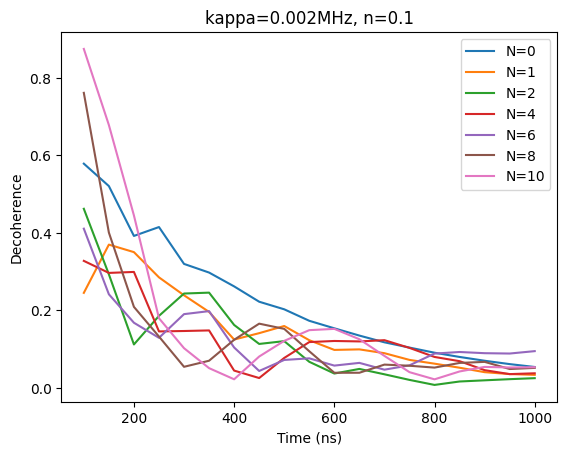

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[0][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[0], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

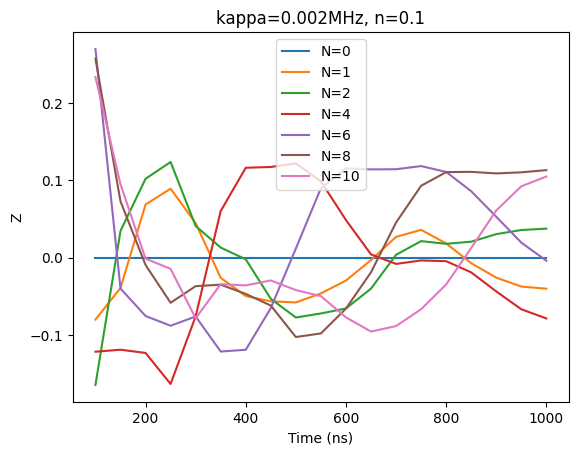

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[0][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[0], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

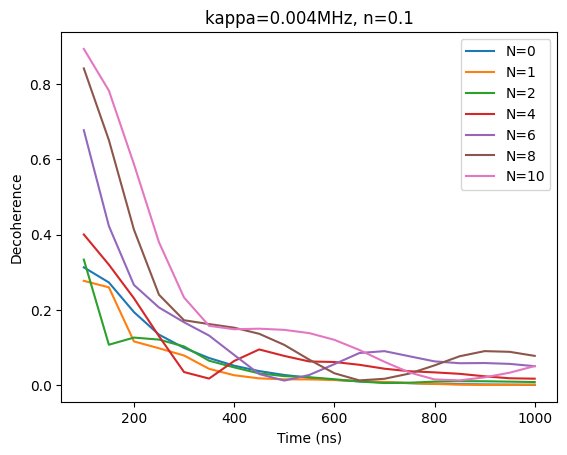

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[1][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[1], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

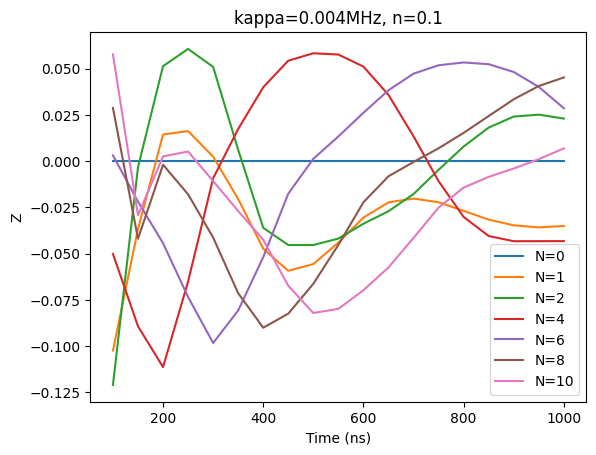

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[1][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[1], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

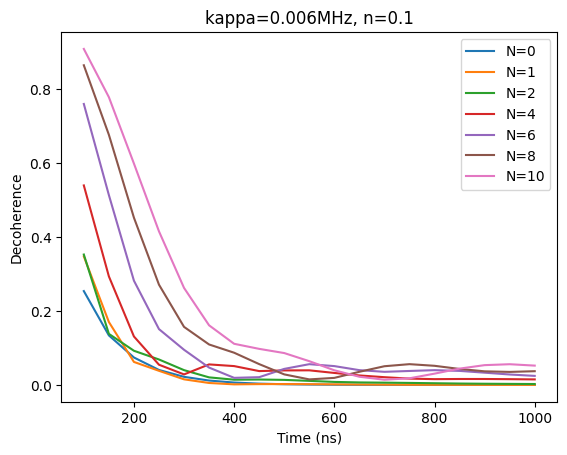

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[2][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[2], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

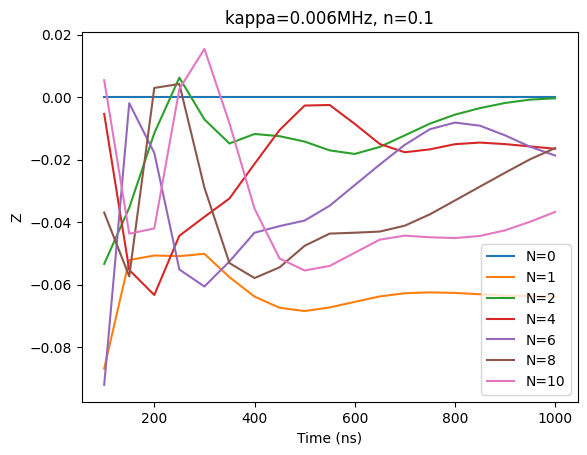

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[2][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[2], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

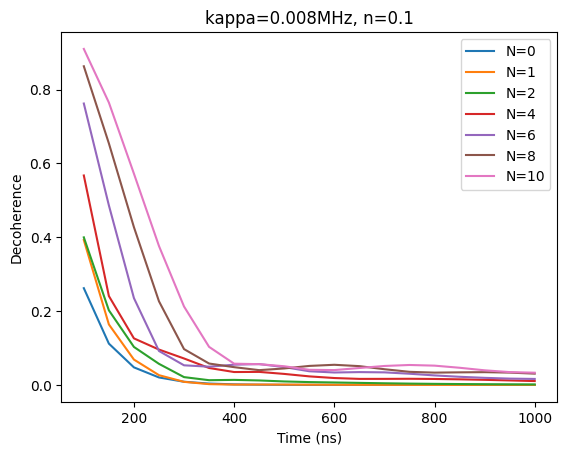

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[3][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[3], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

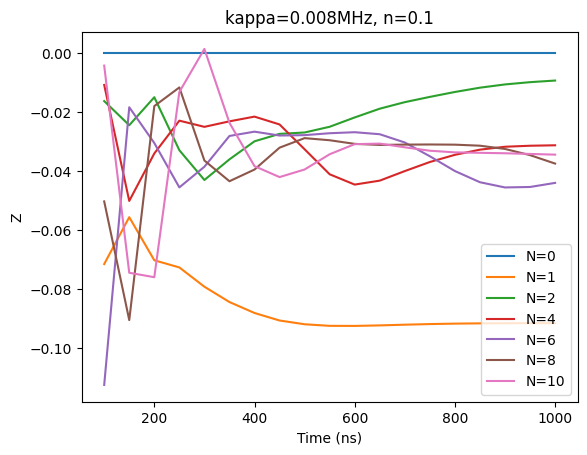

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[3][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[3], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

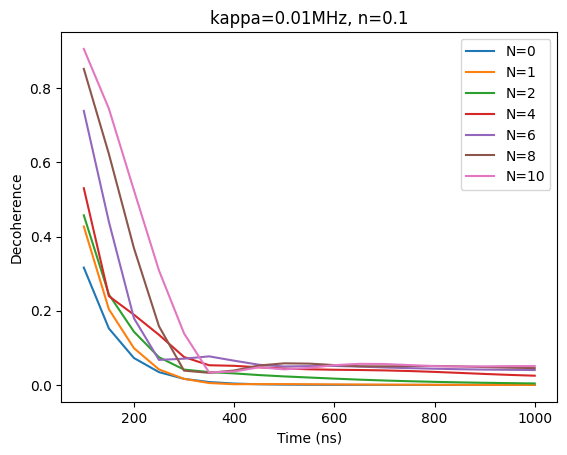

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[4][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[4], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

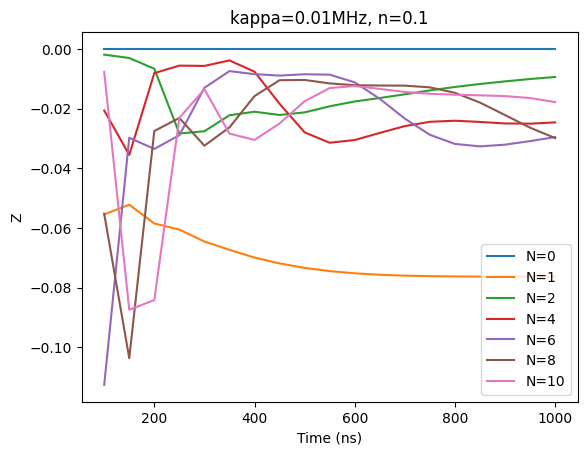

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[4][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[4], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

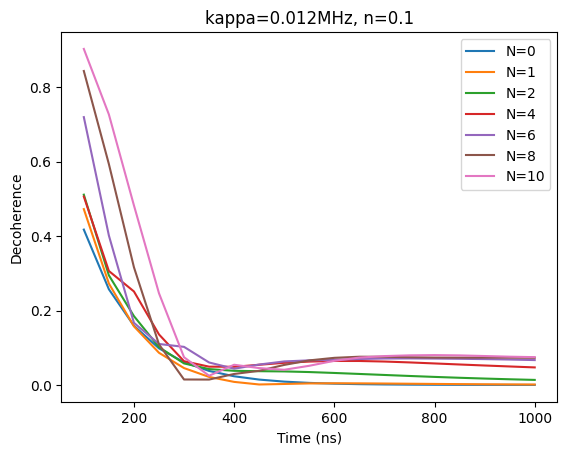

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[5][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[5], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

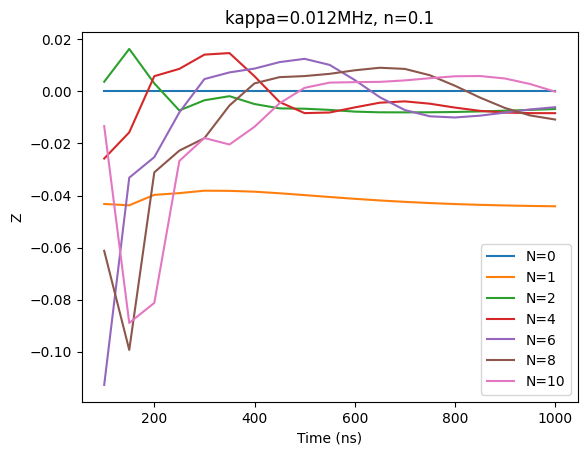

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[5][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[5], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

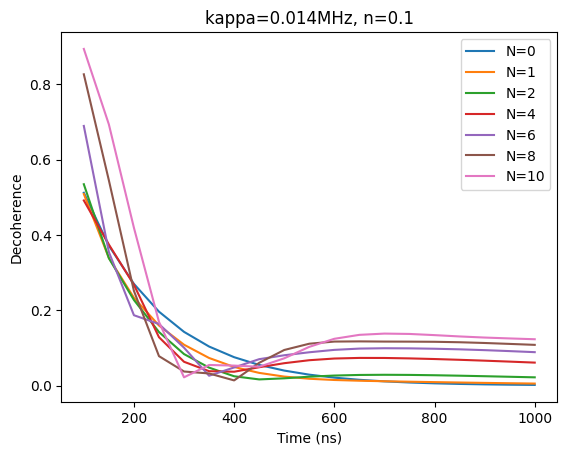

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[6][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[6], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

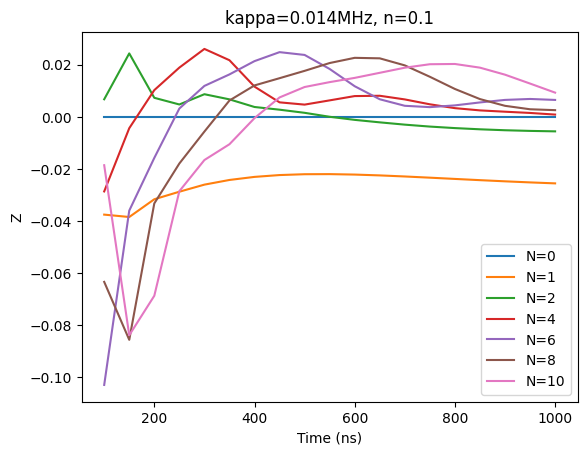

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[6][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[6], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

## 9) DD $n$=0.4

$\kappa = 2\pi0.002, 2\pi0.004, 2\pi0.006, 2\pi0.008, 2\pi0.010, 2\pi0.012, 2\pi0.014$

$N = 0, 1, 2, 4, 6, 8, 10$


In [ ]:
A = [0.013,0.013,0.0135,0.0135,0.01425,0.01525,0.01525]
alpha = [-0.0647j,-0.1245j,-0.1850j,-0.2320j,-0.285j,-0.3350j,-0.3583j]
kappa_seq = [0.002,0.004,0.006,0.008,0.010,0.012,0.014]
N_seq = [0,1,2,4,6,8,10]
tau_list = [50*(k+2) for k in range(19)]
n_exp = 0.4

z_tot = []
plus_tot = []

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0 # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz

kai = g*g/(omega_r-omega_q)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite]

In [ ]:
# iterate for kappa
for i in range(7):

  kappa = 2*np.pi*kappa_seq[i]

  psi_20 = tensor(basis(2,0), basis(N,0))
  psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), coherent(N, alpha[i]))
  psi_21 = tensor(basis(2,1), basis(N,0))

  H0 = -n_exp*kai*sz_composite + (kappa)*number_composite + kai*tensor(sz, a.dag()*a)
  H1 = 0.5*tensor(qeye(2), a + a.dag())
  H2 = 0.5*sx_composite

  z_n = []
  plus_n = []


  # iterate for pi-pulse time N
  for j in range(7):

    z = []
    plus = []


    # iterate for evolution time 100ns ~ 1000ns
    for k in range(19):

      # Simulation
      tlist = np.linspace(0, 50*(k+2), 500*(k+2))

      result = mesolve(
        [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
        psi_2s,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
        e_ops = op_list,
        options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
      )

      x_sub = result.expect[0]
      y_sub = result.expect[1]
      z_sub = result.expect[2]
      plus_sub = result.expect[3]

      z.append(z_sub[-1])
      plus.append(np.abs(2*plus_sub[-1]))

    z_n.append(z)
    plus_n.append(plus)

  z_tot.append(z_n)
  plus_tot.append(plus_n)

  print(i)

0
1
2
3
4
5
6


Text(0, 0.5, 'Decoherence')

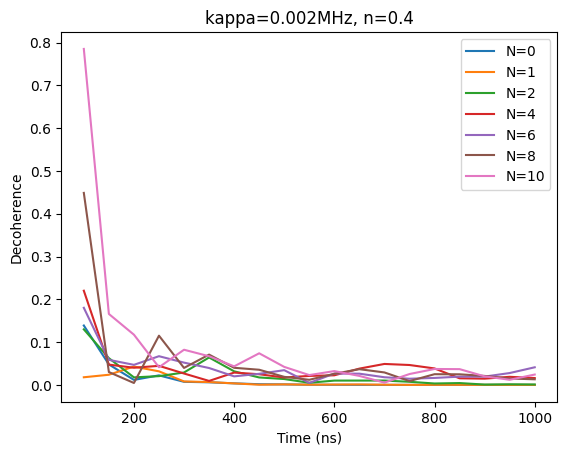

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[0][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[0], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

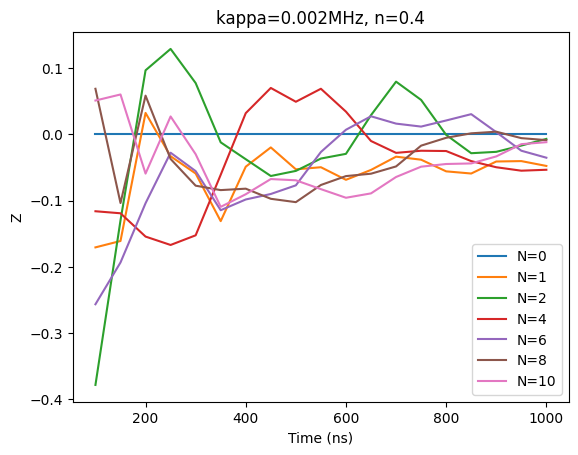

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[0][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[0], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

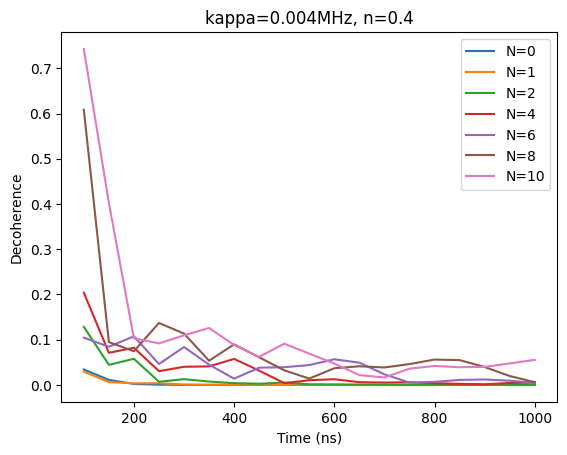

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[1][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[1], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

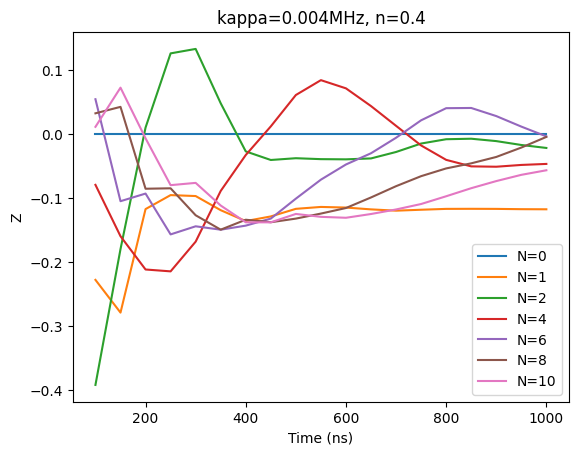

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[1][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[1], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

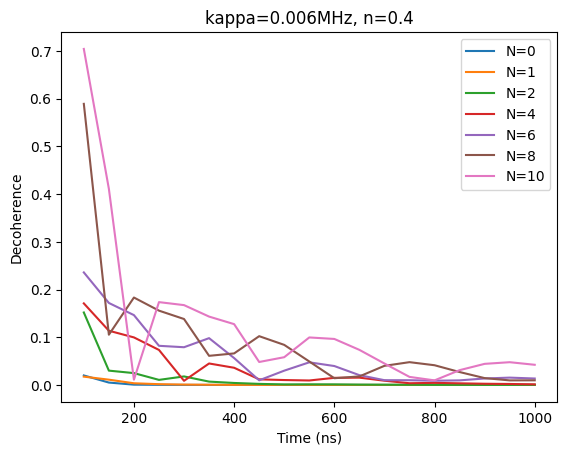

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[2][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[2], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

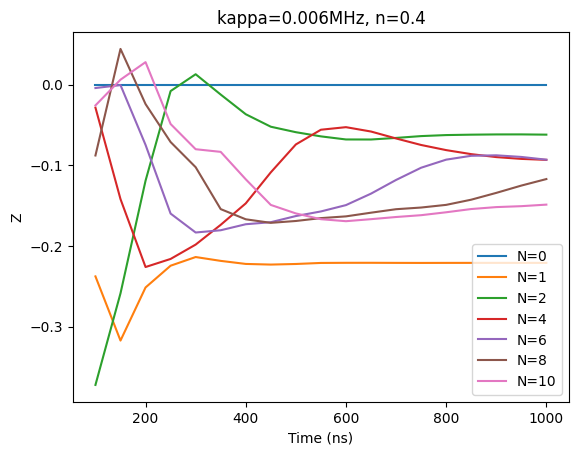

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[2][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[2], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

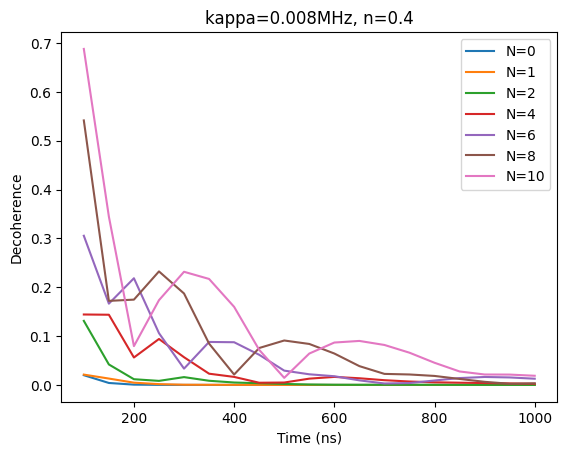

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[3][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[3], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

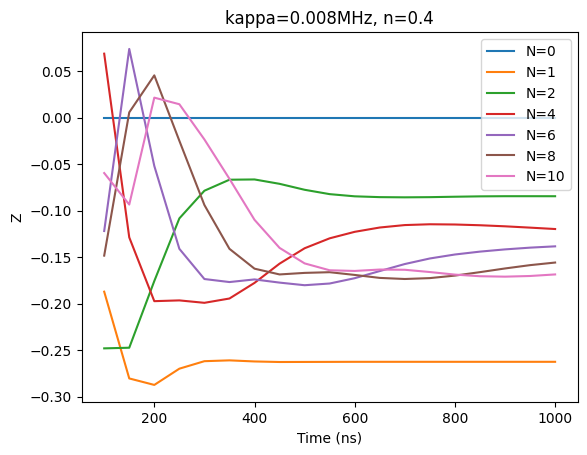

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[3][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[3], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

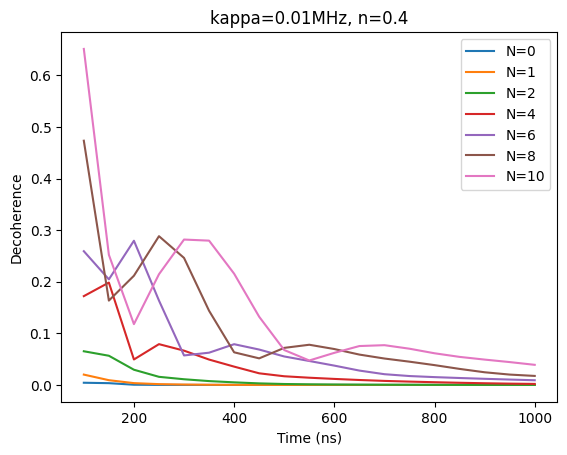

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[4][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[4], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

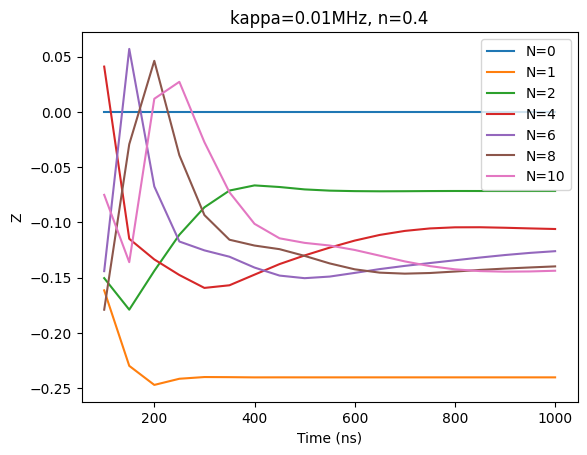

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[4][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[4], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

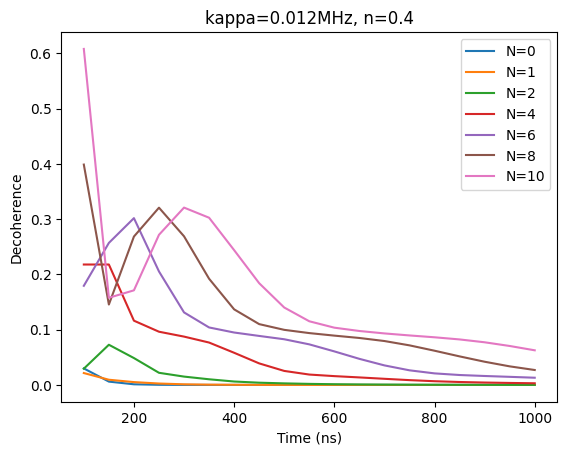

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[5][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[5], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

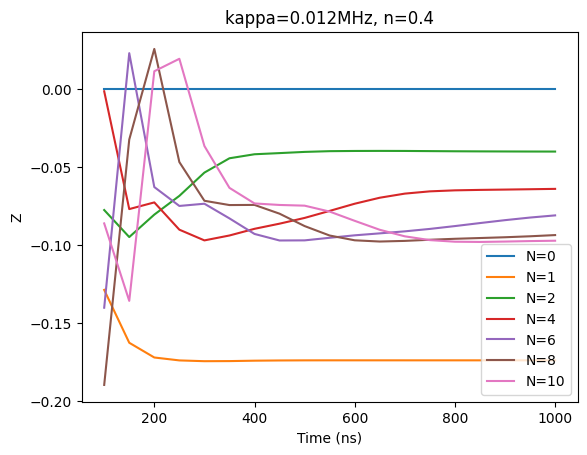

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[5][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[5], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

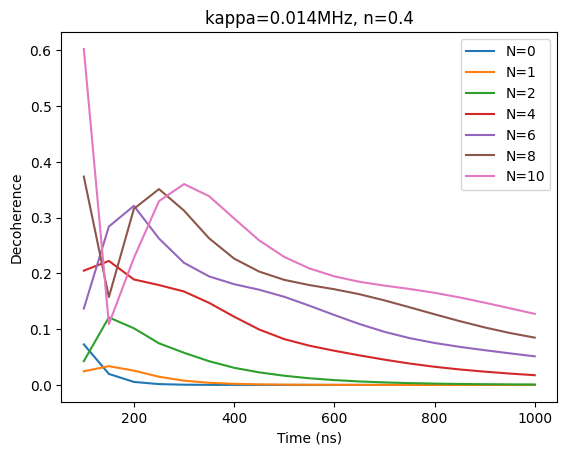

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[6][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[6], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

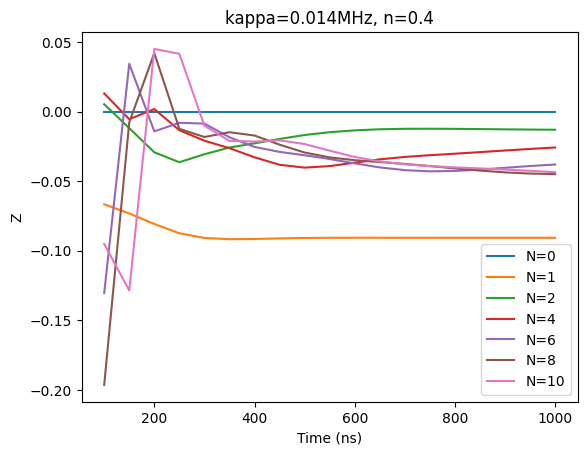

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[6][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[6], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

## 10) DD $n$=1

$\kappa = 2\pi0.002, 2\pi0.004, 2\pi0.006, 2\pi0.008, 2\pi0.010, 2\pi0.012, 2\pi0.014$

$N = 0, 1, 2, 4, 6, 8, 10$


In [ ]:
A = [0.0207,0.0207,0.0215,0.0225,0.023,0.024,0.024]
alpha = [-0.0959j,-0.1869j,-0.2765j,-0.3606j,-0.460j,-0.4948j,-0.5568j]
kappa_seq = [0.002,0.004,0.006,0.008,0.010,0.012,0.014]
N_seq = [0,1,2,4,6,8,10]
tau_list = [50*(k+2) for k in range(19)]
n_exp = 1

z_tot = []
plus_tot = []

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0 # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz

kai = g*g/(omega_r-omega_q)

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite]

In [ ]:
# iterate for kappa
for i in range(7):

  kappa = 2*np.pi*kappa_seq[i]

  psi_20 = tensor(basis(2,0), basis(N,0))
  psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), coherent(N, alpha[i]))
  psi_21 = tensor(basis(2,1), basis(N,0))

  H0 = -n_exp*kai*sz_composite + (kappa)*number_composite + kai*tensor(sz, a.dag()*a)
  H1 = 0.5*tensor(qeye(2), a + a.dag())
  H2 = 0.5*sx_composite

  z_n = []
  plus_n = []


  # iterate for pi-pulse time N
  for j in range(7):

    z = []
    plus = []


    # iterate for evolution time 100ns ~ 1000ns
    for k in range(19):

      # Simulation
      tlist = np.linspace(0, 50*(k+2), 500*(k+2))

      result = mesolve(
        [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
        psi_2s,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'B': 2*np.pi*0.05, 'T_srt_q': -10, 'T_end_q': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T_srt_r': 0, 'T_end_r': 1500},
        e_ops = op_list,
        options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
      )

      x_sub = result.expect[0]
      y_sub = result.expect[1]
      z_sub = result.expect[2]
      plus_sub = result.expect[3]

      z.append(z_sub[-1])
      plus.append(np.abs(2*plus_sub[-1]))

    z_n.append(z)
    plus_n.append(plus)

  z_tot.append(z_n)
  plus_tot.append(plus_n)

  print(i)

0
1
2
3
4
5
6


Text(0, 0.5, 'Decoherence')

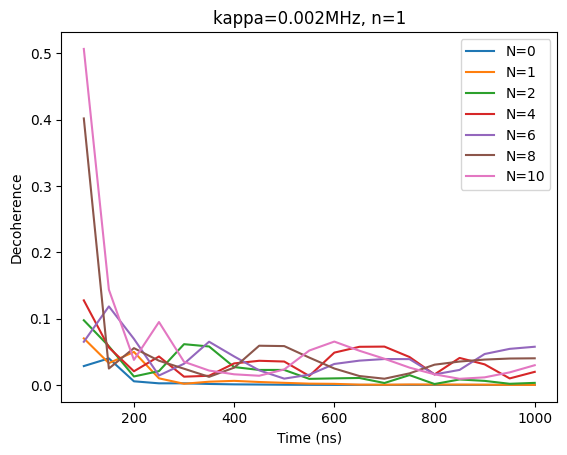

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[0][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[0], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

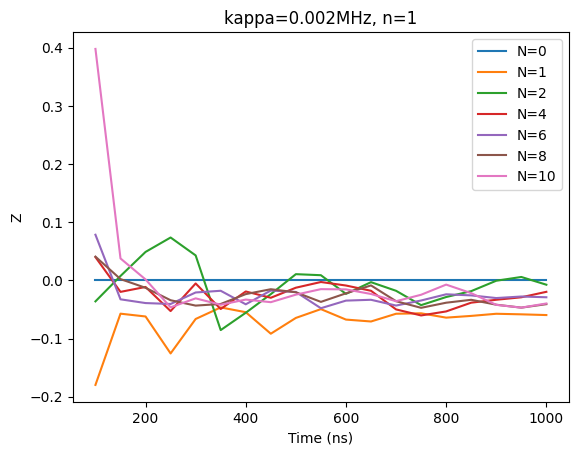

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[0][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[0], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

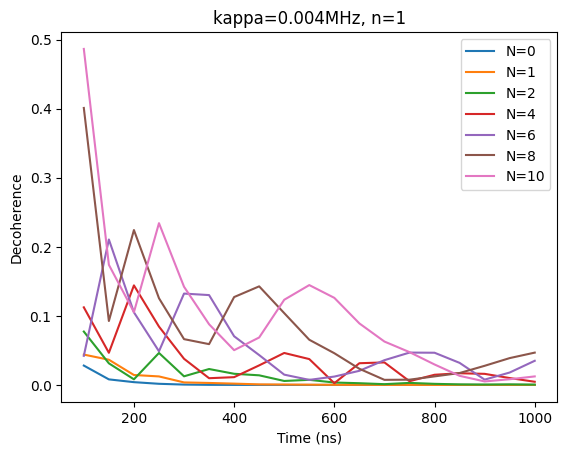

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[1][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[1], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

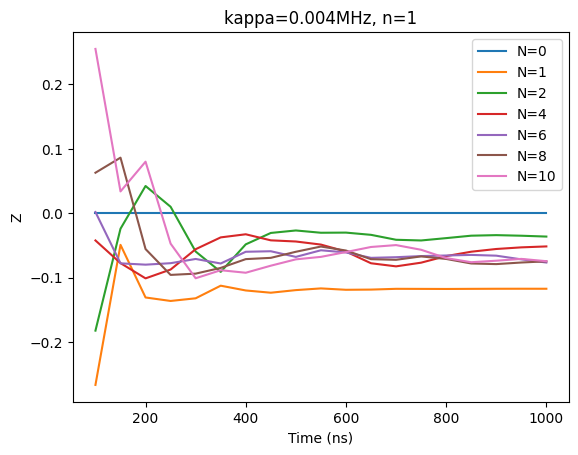

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[1][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[1], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

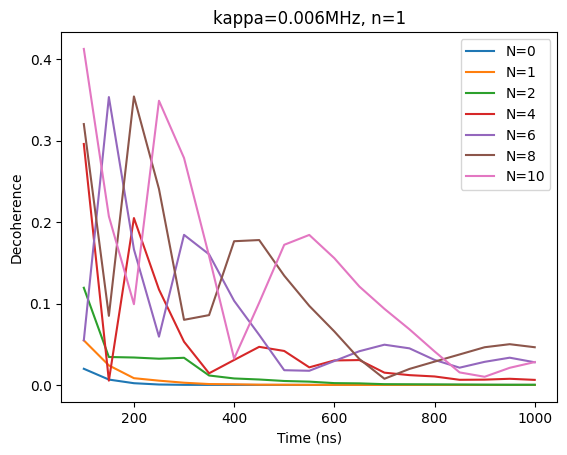

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[2][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[2], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

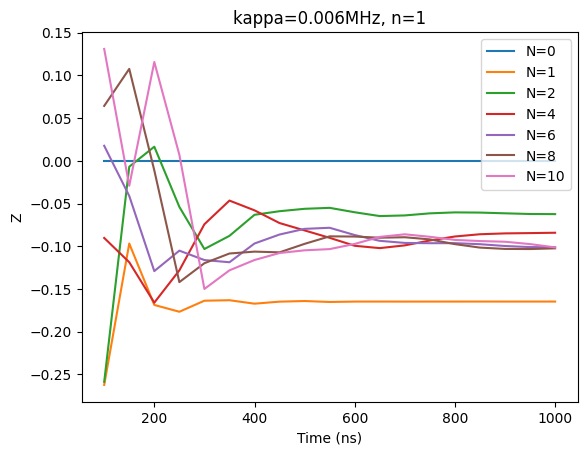

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[2][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[2], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

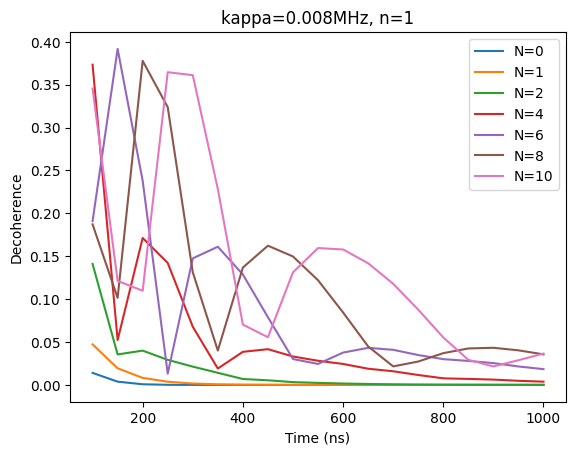

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[3][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[3], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

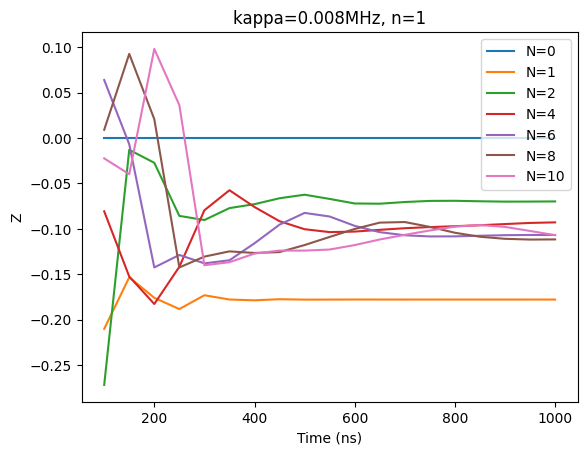

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[3][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[3], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

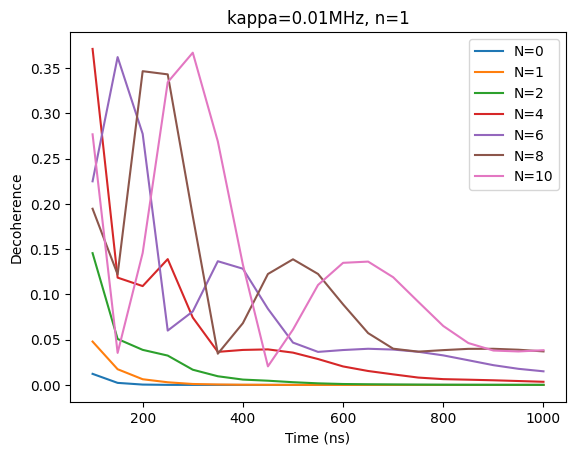

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[4][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[4], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

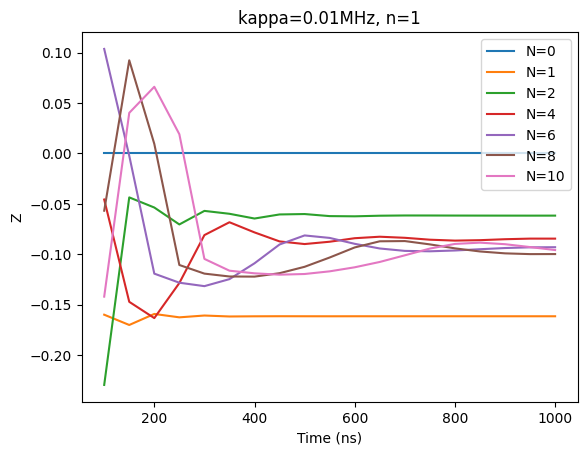

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[4][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[4], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

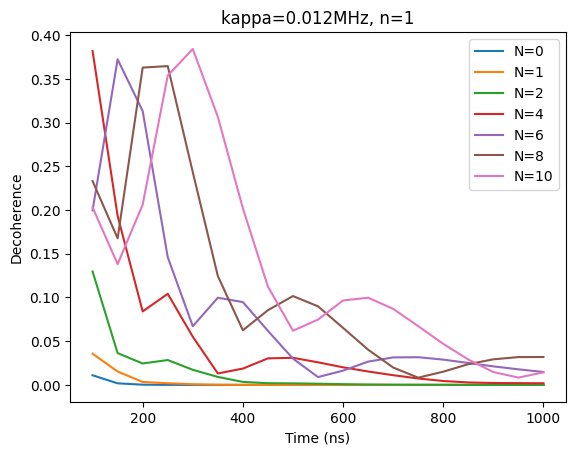

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[5][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[5], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

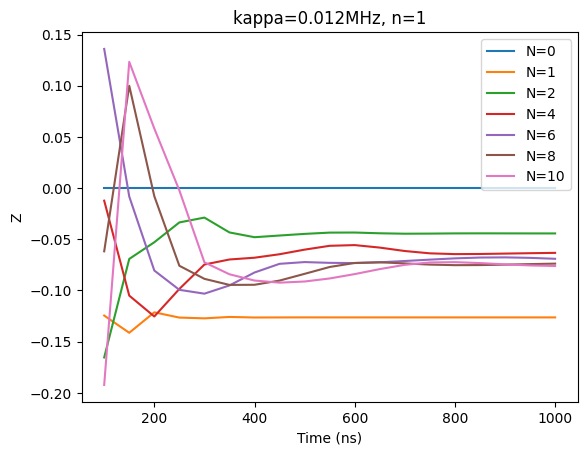

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[5][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[5], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Decoherence')

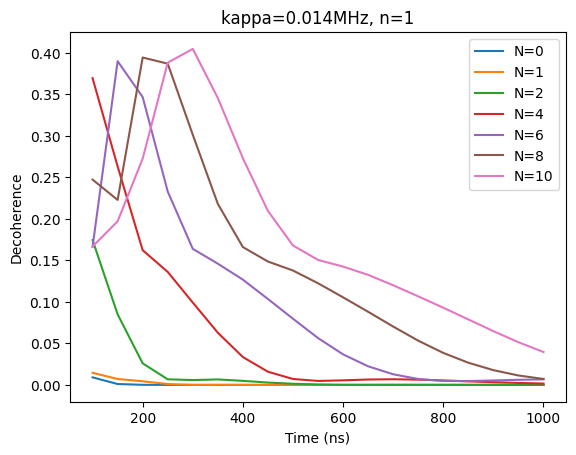

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, plus_tot[6][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[6], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z')

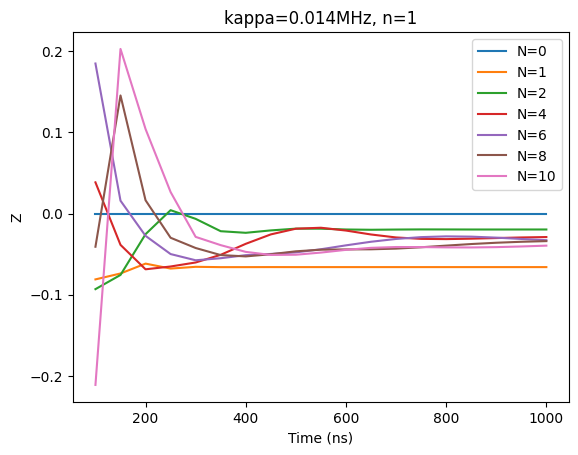

In [ ]:
# Plot Results

for j in range(7):

  plt.plot(tau_list, z_tot[6][j], label = 'N={0}'.format(N_seq[j]))

plt.legend(loc = 0)
plt.title('kappa={0}MHz, n={1}'.format(kappa_seq[6], n_exp))
plt.xlabel('Time (ns)')
plt.ylabel('Z')